In [1]:
!pip install ISLP l0bnb
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path

## Subset Selection Methods
Here we implement methods that reduce the number of parameters in a
model by restricting the model to a subset of the input variables.

### Forward Selection

We will  apply the forward-selection approach to the  `score`
data.  We wish to predict a student’s `z_final_score` on the
basis of incentives and other co-variates

First of all, we note that the `z_final_score` variable is missing for
some of the players.  The `np.isnan()`  function can be used to
identify the missing observations. It returns an array
of the same shape as the input vector, with a `True` for any elements that
are missing, and a `False` for non-missing elements.  The
`sum()`  method can then be used to count all of the
missing elements.

In [2]:
#read the dta file
score = pd.read_stata('Pay_by_Design_JOLE.dta') 





In [3]:
#check the original entries and 
score.shape



(9072, 58)

In [4]:
score.describe

<bound method NDFrame.describe of       z_final_score  any_incentive  levels  gains  p4p  treatment4groups  \
0               NaN            1.0       1      0    0               2.0   
1               NaN            1.0       1      0    0               2.0   
2               NaN            1.0       0      0    1               4.0   
3               NaN            1.0       1      0    0               2.0   
4               NaN            1.0       1      0    0               2.0   
...             ...            ...     ...    ...  ...               ...   
9067       0.830286            1.0       0      1    0               3.0   
9068            NaN            1.0       0      1    0               3.0   
9069       0.830286            1.0       0      1    0               3.0   
9070       0.633310            1.0       0      1    0               3.0   
9071      -0.154593            1.0       0      1    0               3.0   

      small  big  zmathbase1  zmathbase2  ...  sch_nu

We first choose the best model using forward selection based on $C_p$ (\ref{Ch6:eq:cp}). This score
is not built in as a metric to `sklearn`. We therefore define a function to compute it ourselves, and use
it as a scorer. By default, `sklearn` tries to maximize a score, hence
  our scoring function  computes the negative $C_p$ statistic.
  
  return a penalized SSR, taking into account of the model complexity

In [5]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n


Clean the data set to be a basic model with `z_final_score` as the response variable, `small`, `big`,  `zmathbase1` , `zmathbase2`,`countyid` 

In [6]:
##define different groups


response = ['z_final_score']

#treatments
inc_size = ['small','big']
inc_design= ['gains', 'p4p','levels']

#X
base_covs = ['zmathbase1', 'zmathbase2']
other_covs = list('female stuage dad_jhs_yn mom_jhs_yn ses class_size teacher_experience teacher_basepay'.split())
item_difficulty = list('t_taught_any t_taught_easy t_taught_med t_taught_hard easyscore mediumscore hardscore'.split())
secondary_stu = list('secondary_stu math_self_concept math_anxiety math_intrin_mtv math_instr_mtv stu_time_math stu_percept_t_practice t_cares t_can_manage t_communicates parents_help_hmwk teacher_tutor_times substitute_time'.split())

#catogery
#catogery = ['countyid','treatment4groups','t_taught_easy','t_taught_med',
            #'t_taught_hard','va_tutor_norm_terc','pctrank_3bins','avg_pctrank_3bins']

category = ['countyid']

FE = ['schid']


#variable of interest
VoI = ['same_sex','f_same_sex']

Interactions = ['same_sex_x_gains', 'same_sex_x_p4p', 'same_sex_x_levels',
               'f_same_sex_x_gains', 'f_same_sex_x_p4p', 'f_same_sex_x_levels']



In [7]:
#create D1 dummy variable =1 if the student's sex match teacher's sex

score['same_sex'] = ((score['female'] == score['t_female']) | (score['female'] + score['t_female'] == 0)).astype(int)


# Create the interaction term of D1x female = 1 if female the female student has a female teacher
score['f_same_sex'] = score['same_sex'] * score['female']

# Create interactions between pay design and VOI
VoI = ['same_sex', 'f_same_sex']
inc_design = ['gains', 'p4p', 'levels']

for v in VoI:
    for d in inc_design:
        # Create an interaction term by multiplying the variables
        score[f'{v}_x_{d}'] = score[v] * score[d]


score.shape


(9072, 66)

In [8]:
sum_vars = response + base_covs + other_covs 

In [9]:
sum_vars.remove('dad_jhs_yn')
sum_vars.remove('mom_jhs_yn')
sum_vars.remove('female')

In [10]:
score[sum_vars].describe()

,z_final_score,zmathbase1,zmathbase2,stuage,ses,class_size,teacher_experience,teacher_basepay
count,8559.000000,7996.000000,8136.000000,7992.000000,7996.000000,9072.000000,9006.000000,9006.000000
mean,0.069884,-0.024245,0.013555,12.027277,-0.601891,44.054672,12.339223,2935.605713
std,1.046860,1.013209,1.026968,1.033325,1.022967,15.722632,9.895316,915.124634
min,-2.715281,-3.270000,-3.209800,9.000000,-2.167915,7.000000,0.083000,0.000000
25%,-0.745521,-0.811465,-0.773053,11.000000,-1.307316,33.000000,5.000000,2688.000000
50%,0.042383,0.134126,0.164158,12.000000,-0.759971,44.000000,9.000000,3000.000000
75%,0.830286,0.701480,0.913926,13.000000,-0.115827,54.000000,16.000000,3400.000000
max,2.800046,2.025307,2.038579,19.000000,4.097287,103.000000,54.000000,5220.000000


In [11]:
score[sum_vars].describe().to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n & z_final_score & zmathbase1 & zmathbase2 & stuage & ses & class_size & teacher_experience & teacher_basepay \\\\\n\\midrule\ncount & 8559.000000 & 7996.000000 & 8136.000000 & 7992.000000 & 7996.000000 & 9072.000000 & 9006.000000 & 9006.000000 \\\\\nmean & 0.069884 & -0.024245 & 0.013555 & 12.027277 & -0.601891 & 44.054672 & 12.339223 & 2935.605713 \\\\\nstd & 1.046860 & 1.013209 & 1.026968 & 1.033325 & 1.022967 & 15.722632 & 9.895316 & 915.124634 \\\\\nmin & -2.715281 & -3.270000 & -3.209800 & 9.000000 & -2.167915 & 7.000000 & 0.083000 & 0.000000 \\\\\n25% & -0.745521 & -0.811465 & -0.773053 & 11.000000 & -1.307316 & 33.000000 & 5.000000 & 2688.000000 \\\\\n50% & 0.042383 & 0.134126 & 0.164158 & 12.000000 & -0.759971 & 44.000000 & 9.000000 & 3000.000000 \\\\\n75% & 0.830286 & 0.701480 & 0.913926 & 13.000000 & -0.115827 & 54.000000 & 16.000000 & 3400.000000 \\\\\nmax & 2.800046 & 2.025307 & 2.038579 & 19.000000 & 4.097287 & 103.000000 & 54.0000

In [12]:
!pip install seaborn
import seaborn as sns

# summary statistic visualization

In [13]:
import matplotlib.pyplot as plt


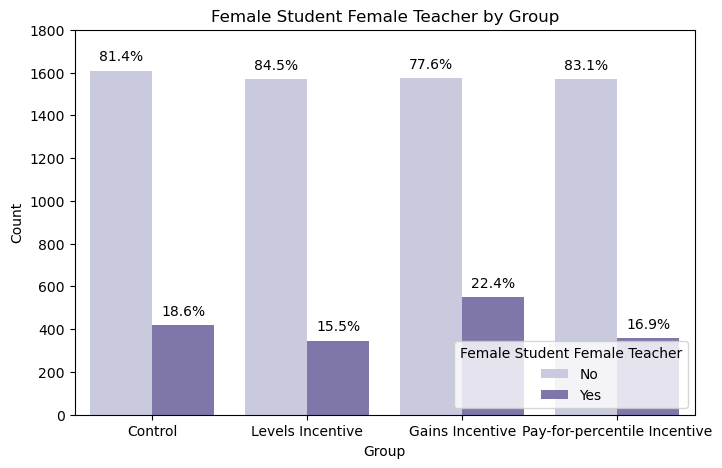

In [53]:




# Modify your `percentages` list to match the exact order of bars in `ax.patches`
percentages = [81.4, 84.5, 77.6, 83.1,18.6, 15.5, 22.4,  16.9  ]  # Example
# Plot with annotations
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=score, x='treatment4groups', hue='f_same_sex', palette='Purples')

# Annotate each bar with the corresponding percentage
for p, percentage in zip(ax.patches, percentages):
    x = p.get_x() + p.get_width() / 2  # Center the annotation horizontally
    y = p.get_height()                 # Place the annotation just above the bar
    
    ax.annotate(f'{percentage}%', (x, y), ha='center', va='bottom', 
                fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Female Student Female Teacher by Group')
ax.legend(title='Female Student Female Teacher', labels=['No', 'Yes'], 
          loc='lower right', bbox_to_anchor=(1, 0))

ax.set_ylim(0, 1800)
ax.set_xticks(range(len(score['treatment4groups'].unique())))  # Set positions
ax.set_xticklabels(['Control', 'Levels Incentive', 'Gains Incentive', 'Pay-for-percentile Incentive'])

plt.show()

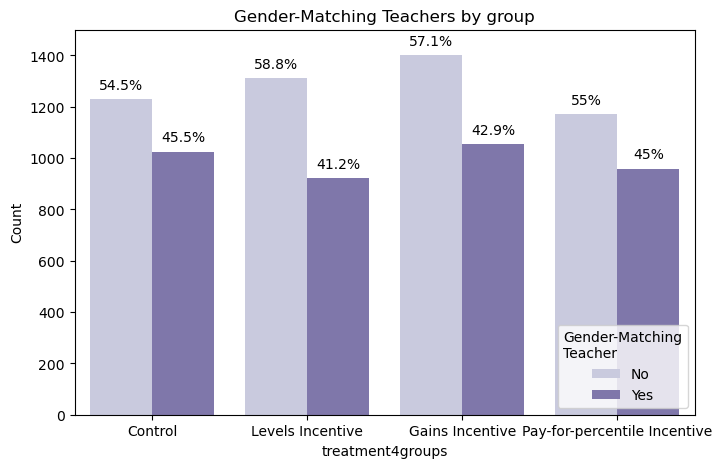

In [80]:




# Modify your `percentages` list to match the exact order of bars in `ax.patches`
percentages = [54.5, 58.8, 57.1, 55, 45.5, 41.2, 42.9, 45]  # Example

# Plot with annotations
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=score, x='treatment4groups', hue='same_sex', palette='Purples')

# Annotate each bar with the corresponding percentage
for p, percentage in zip(ax.patches, percentages):
    x = p.get_x() + p.get_width() / 2  # Center the annotation horizontally
    y = p.get_height()                 # Place the annotation just above the bar
    
    ax.annotate(f'{percentage}%', (x, y), ha='center', va='bottom', 
                fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
plt.xlabel('treatment4groups')
plt.ylabel('Count')
plt.title('Gender-Matching Teachers by group')
ax.set_ylim(0, 1500)
ax.set_xticks(range(len(score['treatment4groups'].unique())))  # Set positions
ax.set_xticklabels(['Control', 'Levels Incentive', 'Gains Incentive', 'Pay-for-percentile Incentive'])
ax.legend(title='Gender-Matching' + '\n' +'Teacher', labels=['No', 'Yes'], loc='lower right', bbox_to_anchor=(1, 0))

plt.show()

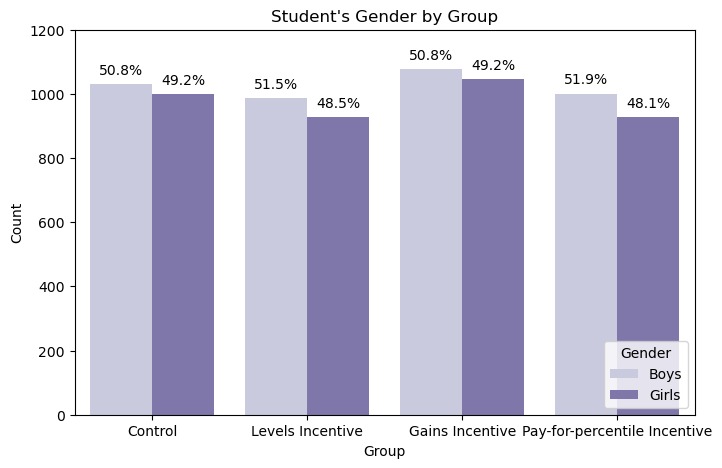

In [26]:




# Modify your `percentages` list to match the exact order of bars in `ax.patches`
percentages = [50.8, 51.5,50.8, 51.9, 49.2, 48.5, 49.2, 48.1] 

# Plot with annotations
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=score, x='treatment4groups', hue='female', palette='Purples')

# Annotate each bar with the corresponding percentage
for p, percentage in zip(ax.patches, percentages):
    x = p.get_x() + p.get_width() / 2  # Center the annotation horizontally
    y = p.get_height()                 # Place the annotation just above the bar
    
    ax.annotate(f'{percentage}%', (x, y), ha='center', va='bottom', 
                fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Student\'s Gender by Group')
ax.set_ylim(0, 1200)
ax.set_xticks(range(len(score['treatment4groups'].unique())))  # Set positions
ax.set_xticklabels(['Control', 'Levels Incentive', 'Gains Incentive', 'Pay-for-percentile Incentive'])
ax.legend(title='Gender', labels=['Boys','Girls'], loc='lower right', bbox_to_anchor=(1, 0))

plt.show()

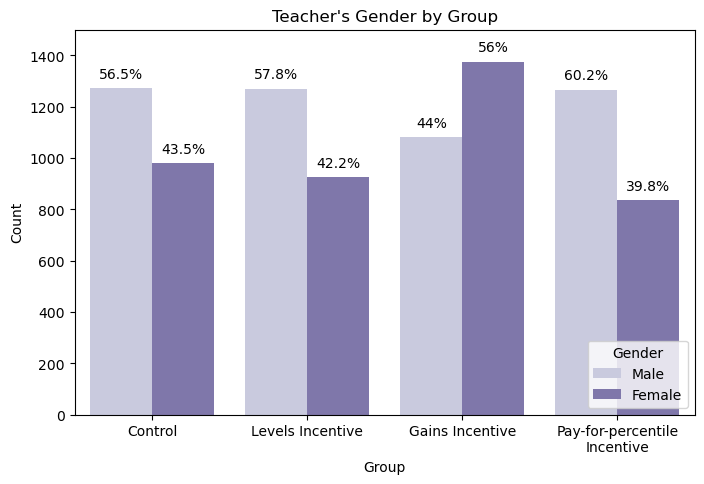

In [78]:




# Modify your `percentages` list to match the exact order of bars in `ax.patches`
percentages = [56.5, 57.8, 44, 60.2, 43.5, 42.2, 56, 39.8] 

# Plot with annotations
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=score, x='treatment4groups', hue='t_female', palette='Purples')

# Annotate each bar with the corresponding percentage
for p, percentage in zip(ax.patches, percentages):
    x = p.get_x() + p.get_width() / 2  # Center the annotation horizontally
    y = p.get_height()                 # Place the annotation just above the bar
    
    ax.annotate(f'{percentage}%', (x, y), ha='center', va='bottom', 
                fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Teacher\'s Gender by Group')
ax.set_ylim(0, 1500)
ax.set_xticks(range(len(score['treatment4groups'].unique())))  # Set positions
ax.set_xticklabels(['Control', 'Levels Incentive', 'Gains Incentive', 'Pay-for-percentile' +'\n' + 'Incentive'])
ax.legend(title='Gender', labels=['Male','Female'], loc='lower right', bbox_to_anchor=(1, 0))

plt.show()

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_132/2083267263.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Boys', 'Girls'])


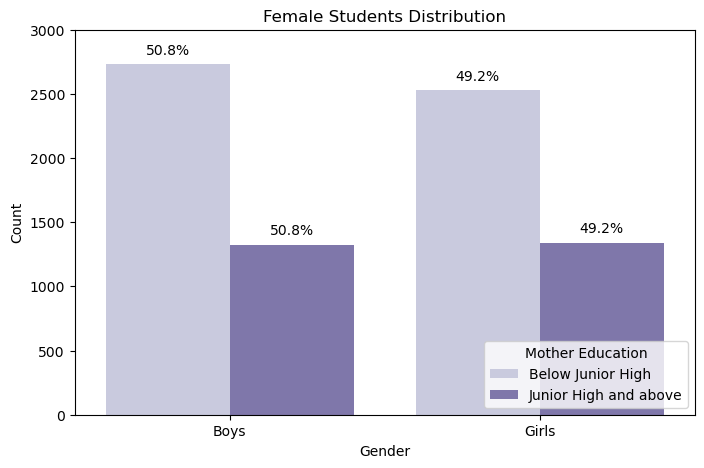

In [19]:
# Modify your `percentages` list to match the exact order of bars in `ax.patches`
percentages = [50.8, 49.2, 50.8, 49.2]  # Example

# Plot with annotations
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=score, x='female', hue='mom_jhs_yn', palette='Purples')

# Annotate each bar with the corresponding percentage
for p, percentage in zip(ax.patches, percentages):
    x = p.get_x() + p.get_width() / 2  # Center the annotation horizontally
    y = p.get_height()                 # Place the annotation just above the bar
    
    ax.annotate(f'{percentage}%', (x, y), ha='center', va='bottom', 
                fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
plt.xlabel('Gender')

ax.legend(title='Mother Education', labels=['Below Junior High', 'Junior High and above'], loc='lower right', bbox_to_anchor=(1, 0))
ax.set_xticklabels(['Boys', 'Girls'])
ax.set_ylim(0, 3000)

plt.ylabel('Count')
plt.title('Female Students Distribution')

plt.show()


/tmp/ipykernel_132/418052512.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Boys', 'Girls'])


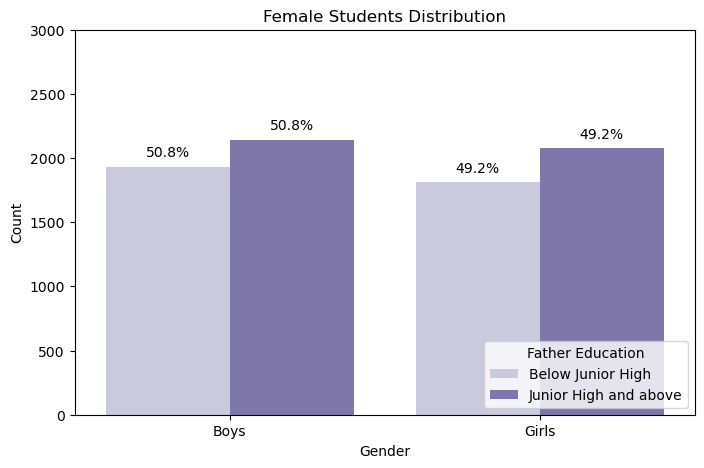

In [20]:
# Modify your `percentages` list to match the exact order of bars in `ax.patches`
percentages = [50.8, 49.2, 50.8, 49.2]  # Example

# Plot with annotations
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=score, x='female', hue='dad_jhs_yn', palette='Purples')

# Annotate each bar with the corresponding percentage
for p, percentage in zip(ax.patches, percentages):
    x = p.get_x() + p.get_width() / 2  # Center the annotation horizontally
    y = p.get_height()                 # Place the annotation just above the bar
    
    ax.annotate(f'{percentage}%', (x, y), ha='center', va='bottom', 
                fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
plt.xlabel('Gender')

ax.legend(title='Father Education', labels=['Below Junior High', 'Junior High and above'], loc='lower right', bbox_to_anchor=(1, 0))
ax.set_xticklabels(['Boys', 'Girls'])
ax.set_ylim(0, 3000)

plt.ylabel('Count')
plt.title('Female Students Distribution')

plt.show()


<Axes: xlabel='treatment4groups', ylabel='zmathbase1'>

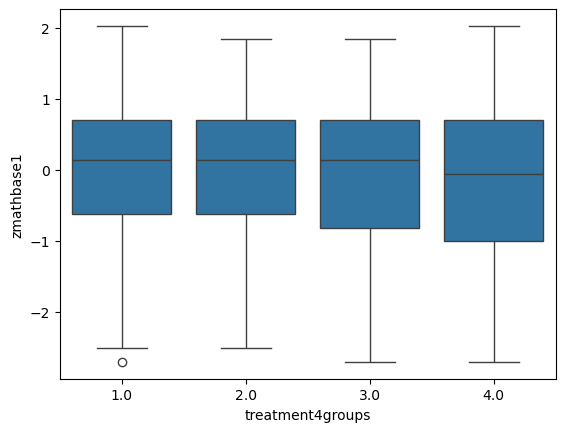

In [66]:
sns.boxplot(data=score[score['female'] == 1], x='treatment4groups', y='zmathbase1')

<Axes: xlabel='treatment4groups', ylabel='zmathbase1'>

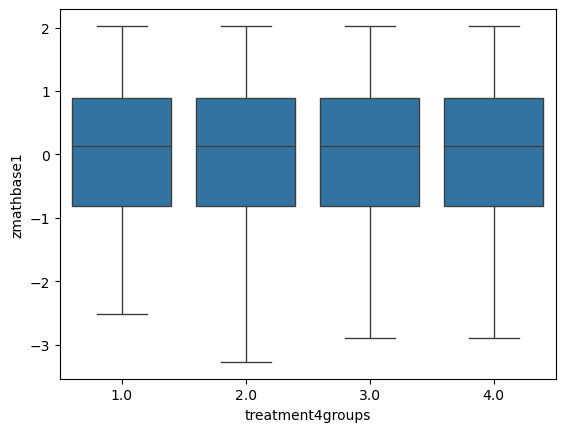

In [70]:
sns.boxplot(data=score[score['female'] == 0], x='treatment4groups', y='zmathbase1')

<Axes: xlabel='treatment4groups', ylabel='zmathbase2'>

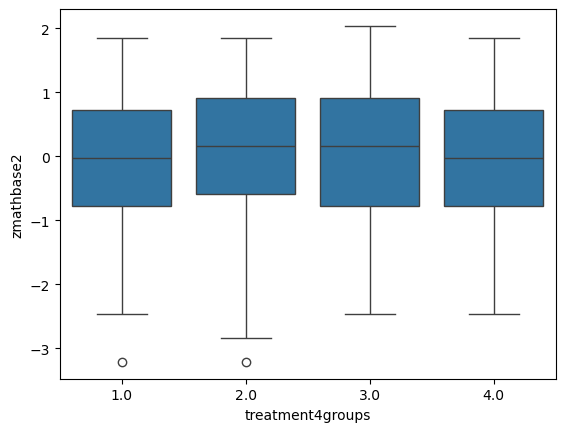

In [71]:
sns.boxplot(data=score[score['female'] == 1], x='treatment4groups', y='zmathbase2')

<Axes: xlabel='treatment4groups', ylabel='zmathbase2'>

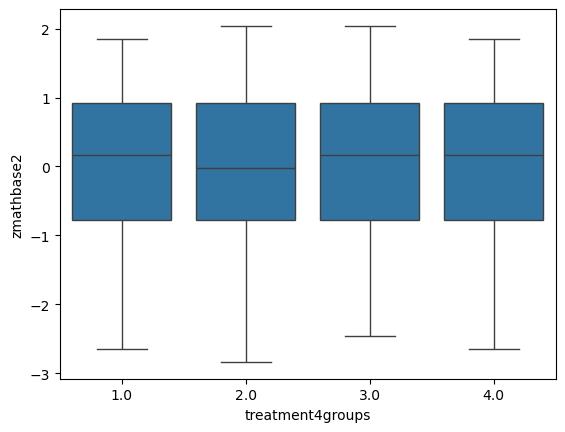

In [72]:
sns.boxplot(data=score[score['female'] == 0], x='treatment4groups', y='zmathbase2')

<Axes: xlabel='treatment4groups', ylabel='stuage'>

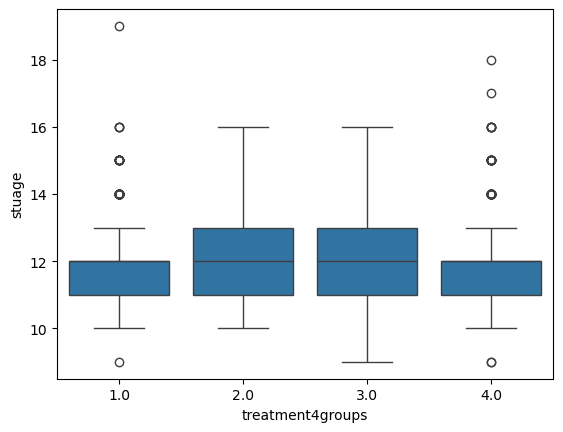

In [64]:
sns.boxplot(data=score[score['female'] == 1], x='treatment4groups', y='stuage')

<Axes: xlabel='treatment4groups', ylabel='stuage'>

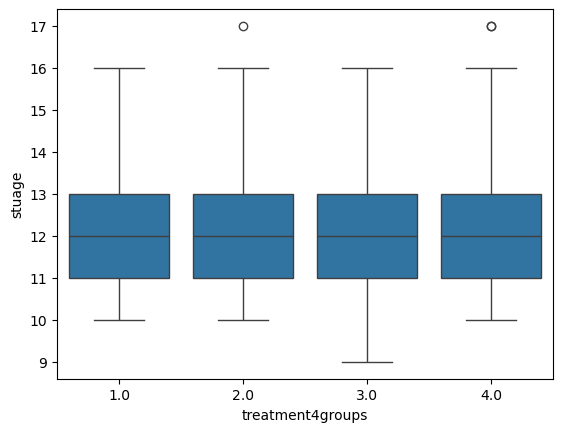

In [65]:
sns.boxplot(data=score[score['female'] == 0], x='treatment4groups', y='stuage')

/tmp/ipykernel_132/833373382.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=score[score['female'] == 0],


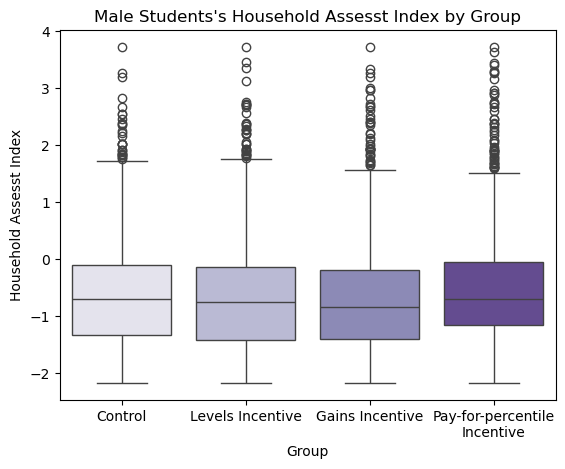

In [117]:
ax = sns.boxplot(data=score[score['female'] == 0], 
                 x='treatment4groups', y='ses',
                palette = 'Purples')

plt.title('Male Students\'s Household Assesst Index by Group')

ax.set_xticks(range(len(score['treatment4groups'].unique())))  # Set positions
ax.set_xticklabels(['Control', 'Levels Incentive', 'Gains Incentive', 'Pay-for-percentile' +'\n' + 'Incentive'])
plt.ylabel('Household Assesst Index')
plt.xlabel('Group')


plt.show()

/tmp/ipykernel_132/3088968112.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=score[score['female'] == 1],


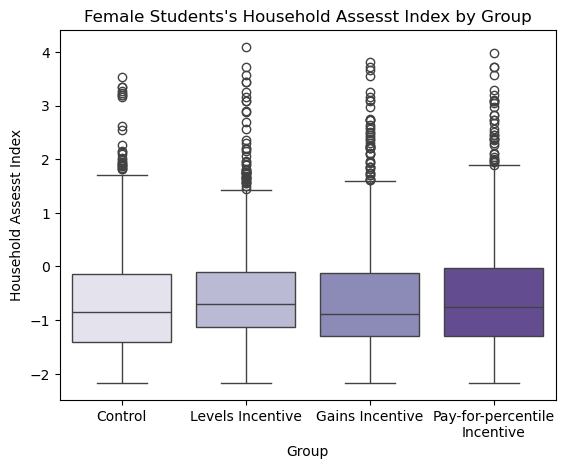

In [116]:
ax = sns.boxplot(data=score[score['female'] == 1], 
                 x='treatment4groups', y='ses',
                palette = 'Purples')

plt.title('Female Students\'s Household Assesst Index by Group')

ax.set_xticks(range(len(score['treatment4groups'].unique())))  # Set positions
ax.set_xticklabels(['Control', 'Levels Incentive', 'Gains Incentive', 'Pay-for-percentile' +'\n' + 'Incentive'])
plt.ylabel('Household Assesst Index')
plt.xlabel('Group')


plt.show()

/tmp/ipykernel_132/430449522.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=score[score['dad_jhs_yn'] == 1], x='treatment4groups', y='z_final_score', palette='Purples')


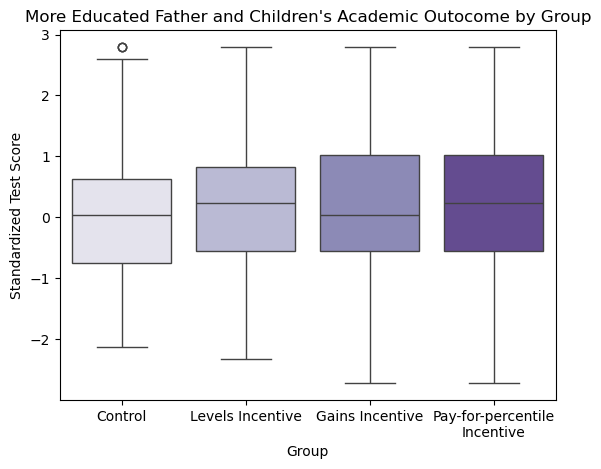

In [109]:

ax = sns.boxplot(data=score[score['dad_jhs_yn'] == 1], x='treatment4groups', y='z_final_score', palette='Purples')

plt.title('More Educated Father and Children\'s Academic Outocome by Group')

ax.set_xticks(range(len(score['treatment4groups'].unique())))  # Set positions
ax.set_xticklabels(['Control', 'Levels Incentive', 'Gains Incentive', 'Pay-for-percentile' +'\n' + 'Incentive'])
plt.ylabel('Standardized Test Score')
plt.xlabel('Group')


plt.show()

/tmp/ipykernel_132/1956418124.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=score[score['dad_jhs_yn'] == 0],


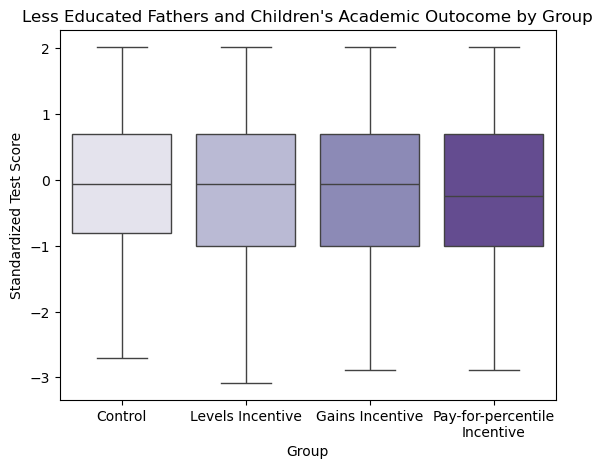

In [110]:
ax = sns.boxplot(data=score[score['dad_jhs_yn'] == 0], 
                 x='treatment4groups', y='zmathbase1',
                palette='Purples')

plt.title('Less Educated Fathers and Children\'s Academic Outocome by Group')

ax.set_xticks(range(len(score['treatment4groups'].unique())))  # Set positions
ax.set_xticklabels(['Control', 'Levels Incentive', 'Gains Incentive', 'Pay-for-percentile' +'\n' + 'Incentive'])
plt.ylabel('Standardized Test Score')
plt.xlabel('Group')


plt.show()

/tmp/ipykernel_132/1758178395.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=score[score['mom_jhs_yn'] == 1],


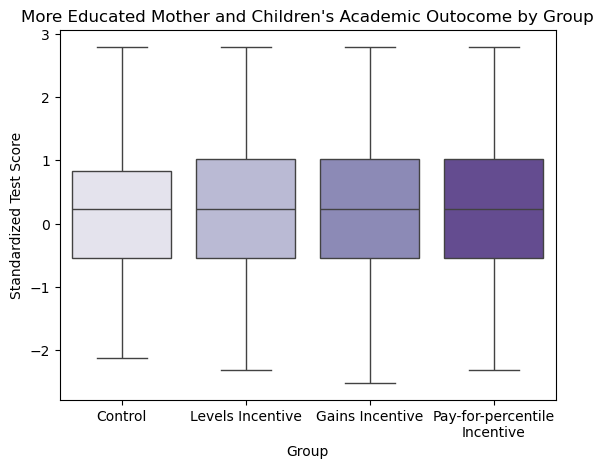

In [112]:
ax = sns.boxplot(data=score[score['mom_jhs_yn'] == 1], 
                 x='treatment4groups', y='z_final_score', 
                 palette='Purples')

plt.title('More Educated Mother and Children\'s Academic Outocome by Group')

ax.set_xticks(range(len(score['treatment4groups'].unique())))  # Set positions
ax.set_xticklabels(['Control', 'Levels Incentive', 'Gains Incentive', 'Pay-for-percentile' +'\n' + 'Incentive'])
plt.ylabel('Standardized Test Score')
plt.xlabel('Group')


plt.show()

/tmp/ipykernel_132/3655747932.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=score[score['mom_jhs_yn'] == 0],


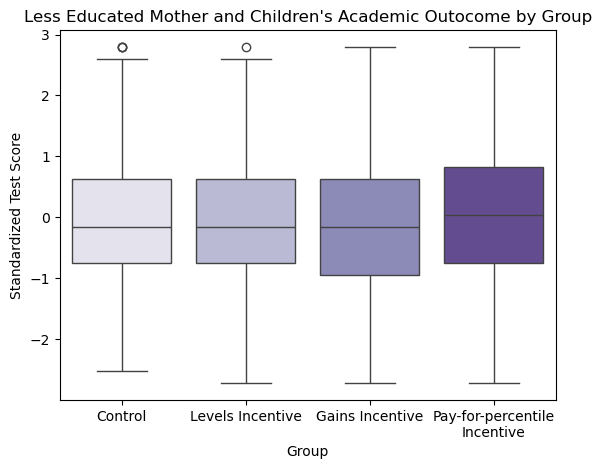

In [113]:
ax = sns.boxplot(data=score[score['mom_jhs_yn'] == 0],
                 x='treatment4groups', y='z_final_score',
                palette='Purples')

plt.title('Less Educated Mother and Children\'s Academic Outocome by Group')

ax.set_xticks(range(len(score['treatment4groups'].unique())))  # Set positions
ax.set_xticklabels(['Control', 'Levels Incentive', 'Gains Incentive', 'Pay-for-percentile' +'\n' + 'Incentive'])
plt.ylabel('Standardized Test Score')
plt.xlabel('Group')


plt.show()

# Now, select the subset 

In [33]:
# Concatenate the lists
co_variates = base_covs + other_covs + FE
dummies = category+inc_size + inc_design+ VoI + Interactions


In [34]:
score_sub = score[co_variates+ dummies + response]

# treat the missing value

In [35]:
#check if total missing
np.isnan(score_sub['z_final_score']).sum()


513

In [36]:
score_sub = score_sub.dropna()
score_sub.shape

(7373, 26)

In [37]:
score_sub.describe()

,zmathbase1,zmathbase2,female,stuage,dad_jhs_yn,mom_jhs_yn,ses,class_size,teacher_experience,teacher_basepay,...,levels,same_sex,f_same_sex,same_sex_x_gains,same_sex_x_p4p,same_sex_x_levels,f_same_sex_x_gains,f_same_sex_x_p4p,f_same_sex_x_levels,z_final_score
count,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,...,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000
mean,-0.006386,0.032315,0.492473,11.997423,0.534382,0.340703,-0.601698,42.535061,12.302465,2956.353760,...,0.235454,0.497898,0.214567,0.135359,0.121796,0.114065,0.071341,0.046928,0.044894,0.068698
std,1.008237,1.021582,0.499981,1.010451,0.498842,0.473988,1.022242,14.560350,9.963124,903.198181,...,0.424311,0.500029,0.410549,0.342130,0.327072,0.317912,0.257412,0.211499,0.207084,1.043120
min,-3.270000,-3.209800,0.000000,9.000000,0.000000,0.000000,-2.167915,7.000000,0.083000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.715281
25%,-0.811465,-0.773053,0.000000,11.000000,0.000000,0.000000,-1.290093,33.000000,5.000000,2700.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.745521
50%,0.134126,0.164158,0.000000,12.000000,1.000000,0.000000,-0.759971,42.000000,9.000000,3000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042383
75%,0.701480,0.913926,1.000000,13.000000,1.000000,1.000000,-0.122620,52.000000,16.000000,3406.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.830286
max,2.025307,2.038579,1.000000,19.000000,1.000000,1.000000,4.097287,103.000000,54.000000,5220.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.800046


# Summary Statistics

In [38]:
# Generate LaTeX code with automatic escaping of special characters using DataFrame.to_latex()
#latex_code = control.describe().to_latex(escape=True)


# transform dummy and fixed effects

In [39]:
#Treat Fixed effect on contunious variables
score_cont = score_sub[co_variates]

school_means = score_cont.groupby('schid').transform('mean')
score_cont = score_cont - school_means
score_cont.drop(columns='schid', inplace=True)
score_transformed = score_cont

score_transformed['z_final_score'] = score_sub['z_final_score']

for i in dummies:
    score_transformed[i] = score_sub[i]
    


In [40]:
#treat dummy
score_encoded = pd.get_dummies(score_transformed, columns=['countyid'], drop_first=True)

In [41]:
score_encoded.shape

(7373, 39)

In [42]:
score_encoded.describe()

,class_size,dad_jhs_yn,female,mom_jhs_yn,ses,stuage,teacher_basepay,teacher_experience,zmathbase1,zmathbase2,...,p4p,levels,same_sex,f_same_sex,same_sex_x_gains,same_sex_x_p4p,same_sex_x_levels,f_same_sex_x_gains,f_same_sex_x_p4p,f_same_sex_x_levels
count,7.373000e+03,7.373000e+03,7.373000e+03,7.373000e+03,7.373000e+03,7.373000e+03,7373.000000,7.373000e+03,7.373000e+03,7.373000e+03,...,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000
mean,-8.148851e-09,-3.645964e-09,-4.042089e-09,-2.215065e-09,3.252518e-18,3.013782e-08,0.000003,-3.233671e-09,2.457590e-09,-7.760811e-10,...,0.240879,0.235454,0.497898,0.214567,0.135359,0.121796,0.114065,0.071341,0.046928,0.044894
std,5.314953e+00,4.756159e-01,4.903067e-01,4.466593e-01,9.430391e-01,9.004887e-01,206.435226,1.957272e+00,8.852610e-01,8.928924e-01,...,0.427646,0.424311,0.500029,0.410549,0.342130,0.327072,0.317912,0.257412,0.211499,0.207084
min,-4.373333e+01,-9.024390e-01,-8.421053e-01,-8.139535e-01,-2.697501e+00,-3.296296e+00,-1393.548340,-1.243243e+01,-2.967198e+00,-2.932918e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,-4.666667e-01,-4.814815e-01,-3.478261e-01,-6.002458e-01,-6.615381e-01,0.000000,0.000000e+00,-6.044363e-01,-6.164764e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,1.904762e-01,-2.978723e-01,-1.714286e-01,-1.388402e-01,0.000000e+00,0.000000,0.000000e+00,3.636888e-02,5.553845e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000e+00,4.313725e-01,4.857143e-01,5.000000e-01,4.517266e-01,5.000000e-01,0.000000,0.000000e+00,6.373981e-01,6.511148e-01,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.826667e+01,8.666667e-01,8.421053e-01,9.666666e-01,4.476572e+00,6.828571e+00,1322.000000,1.592982e+01,2.668667e+00,3.068696e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
score_encoded.columns

Index(['class_size', 'dad_jhs_yn', 'female', 'mom_jhs_yn', 'ses', 'stuage',
       'teacher_basepay', 'teacher_experience', 'zmathbase1', 'zmathbase2',
       'z_final_score', 'small', 'big', 'gains', 'p4p', 'levels', 'same_sex',
       'f_same_sex', 'same_sex_x_gains', 'same_sex_x_p4p', 'same_sex_x_levels',
       'f_same_sex_x_gains', 'f_same_sex_x_p4p', 'f_same_sex_x_levels',
       'countyid_104', 'countyid_105', 'countyid_106', 'countyid_107',
       'countyid_108', 'countyid_109', 'countyid_110', 'countyid_111',
       'countyid_201', 'countyid_202', 'countyid_203', 'countyid_204',
       'countyid_205', 'countyid_206', 'countyid_207'],
      dtype='object')

We need to estimate the residual variance $\sigma^2$, which is the first argument in our scoring function above.
We will fit the biggest model, using `z_final_score` as the response variable, `small`, `big`,  `zmathbase1` , `zmathbase2`,`countyid` and estimate $\sigma^2$ based on its MSE.

In [44]:
design = MS(score_encoded.columns.drop('z_final_score')).fit(score_encoded) #specify a modelof X for transform
Y = np.array(score_encoded['z_final_score'])
X = design.transform(score_encoded) #Standardized
sigma2 = OLS(Y,X).fit().scale #extract the sigma2



In [45]:
len(design.terms)


38

Use partial to fix the function argument


In [46]:
neg_Cp = partial(nCp, sigma2) #fix sigma2 to the standardized value


Along with a score we need to specify the search strategy. This is done through the object
`Stepwise()`  in the `ISLP.models` package. The method `Stepwise.first_peak()`
runs forward stepwise until any further additions to the model do not result
in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()`
runs a fixed number of steps of stepwise search.

`Stepwise()` Starting with no predictors, the algorithm adds predictors one at a time based on the improvement in model fit.

In [47]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms)) 
                               #max_term = # of predictors

function `sklearn_selected()`  from the `ISLP.models` package. 

This takes a model from `statsmodels` along with a search strategy and selects a model with its `fit` method. 

The selection strategy will be applied to find the best model based on `MSE` DEFAULT OPTION

In [48]:
OLS_MSE = sklearn_selected(OLS,strategy) #default using MSE to evalute diff models

OLS_MSE.fit(score_encoded, Y) #apply the searching frame to dataset score and Y
OLS_MSE.selected_state_


('big',
 'class_size',
 'countyid_104',
 'countyid_105',
 'countyid_106',
 'countyid_107',
 'countyid_108',
 'countyid_109',
 'countyid_110',
 'countyid_111',
 'countyid_201',
 'countyid_202',
 'countyid_203',
 'countyid_204',
 'countyid_205',
 'countyid_206',
 'countyid_207',
 'dad_jhs_yn',
 'f_same_sex',
 'f_same_sex_x_gains',
 'f_same_sex_x_levels',
 'f_same_sex_x_p4p',
 'female',
 'levels',
 'mom_jhs_yn',
 'p4p',
 'same_sex',
 'same_sex_x_gains',
 'same_sex_x_levels',
 'same_sex_x_p4p',
 'ses',
 'small',
 'stuage',
 'teacher_basepay',
 'teacher_experience',
 'zmathbase1',
 'zmathbase2')

In [49]:
len(OLS_MSE.selected_state_)


37

Using `neg_Cp` results in a smaller model, as expected, with just 10 variables selected.


In [50]:
OLS_Cp = sklearn_selected(OLS,strategy,scoring=neg_Cp)
OLS_Cp.fit(score_encoded, Y)
OLS_Cp.selected_state_

('countyid_104',
 'countyid_105',
 'countyid_106',
 'countyid_107',
 'countyid_109',
 'countyid_111',
 'countyid_201',
 'countyid_202',
 'countyid_203',
 'countyid_204',
 'countyid_205',
 'countyid_206',
 'countyid_207',
 'dad_jhs_yn',
 'f_same_sex',
 'female',
 'levels',
 'p4p',
 'same_sex',
 'stuage',
 'teacher_basepay',
 'zmathbase1',
 'zmathbase2')

In [51]:
len(OLS_Cp.selected_state_)


23

### Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an  alternative to using $C_p$, we might try cross-validation to select a model in forward selection. For this, we need a
method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()`
estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models`
computes the cross-validated predictions for each of the models
along the path, which we can use to evaluate the cross-validated MSE
along the path.

Here we define a strategy that fits the full forward selection path.
While there are various parameter choices for `sklearn_selection_path()`,
we use the defaults here, which selects the model at each step based on the biggest reduction  in RSS.

In [52]:
#define a search modle with fixed steps
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
#this model stores all the chosen path

#default path,selects the model at each step 
#based on the biggest reduction in RSS.
full_path = sklearn_selection_path(OLS, strategy,scoring=neg_Cp)

In [53]:
#fit the search model on the data
full_path.fit(score_encoded, Y)

#predict y^hat 
Yhat_in = full_path.predict(score_encoded)
Yhat_in.shape


(7373, 39)

This gives us an array of fitted values --- 20 steps in all, including the fitted mean for the null model --- which we can use to evaluate
in-sample MSE. As expected, the in-sample MSE improves each step we take,
indicating we must use either the validation or cross-validation
approach to select the number of steps. We fix the y-axis to range from
50,000 to 250,000 to compare to the cross-validation and validation
set MSE below, as well as other methods such as ridge regression, lasso and
principal components regression.

(0.0, 14.0)

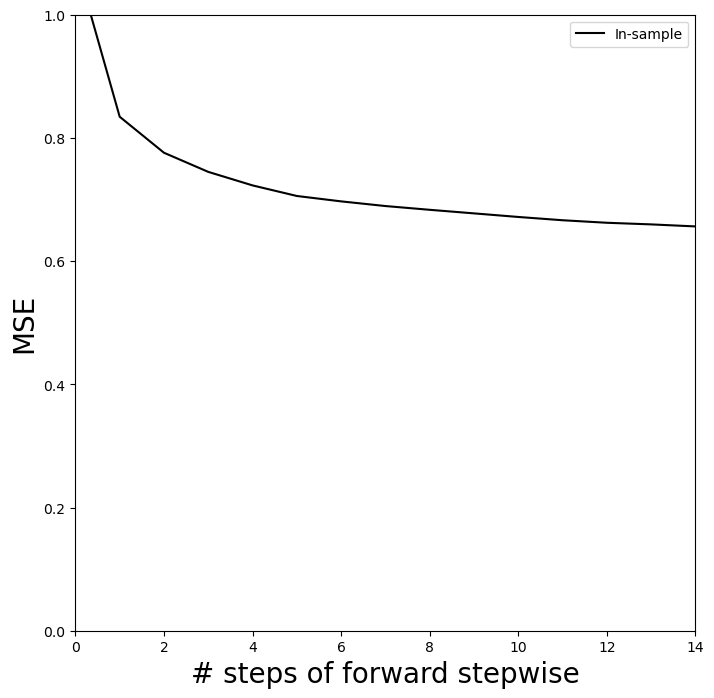

In [54]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([0,1])
ax.set_xlim([0, 14])

In [55]:
print(insample_mse)
print(n_steps)

[1.08794167 0.83438929 0.77594236 0.74488337 0.72292568 0.70574881
 0.69699264 0.68942166 0.6833076  0.67750993 0.67169164 0.66636202
 0.66226242 0.65962789 0.6563335  0.65418575 0.65318682 0.6525013
 0.65199642 0.65154386 0.65114351 0.65082717 0.65047514 0.65011689
 0.64997447 0.64983322 0.64969495 0.64956799 0.64950205 0.64943303
 0.64938431 0.64933706 0.64932339 0.64931447 0.64930833 0.64930585
 0.64930563 0.64930548 0.64930548]
39


`skm.cross_val_predict()`
The prediction matrix `Yhat_cv` is the same shape as `Yhat_in`; the difference is that the predictions in each row, corresponding to a particular sample index, were made from models fit on a training fold that did not include that row.

At each model along the path, we compute the MSE in each of the cross-validation folds.
These we will average to get the  mean MSE, and can also use the individual values to compute a crude estimate of the standard error of the mean. {The estimate is crude because the five error estimates  are based on overlapping training sets, and hence are not independent.}
Hence we must know the test indices for each cross-validation
split. This can be found by using the `split()` method of `kfold`. Because
we  fixed the random state above, whenever we split any array with the same
number of rows as $Y$ we recover the same training and test indices, though we simply
ignore the training indices below.

In [56]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                score_encoded,
                                Y,
                                cv=kfold)
Yhat_cv.shape #the same dimension as the true value


(7373, 39)

In [57]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(39, 5)

We now add the cross-validation error estimates to our MSE plot.
We include the mean error across the five folds, and the estimate of the standard error of the mean.

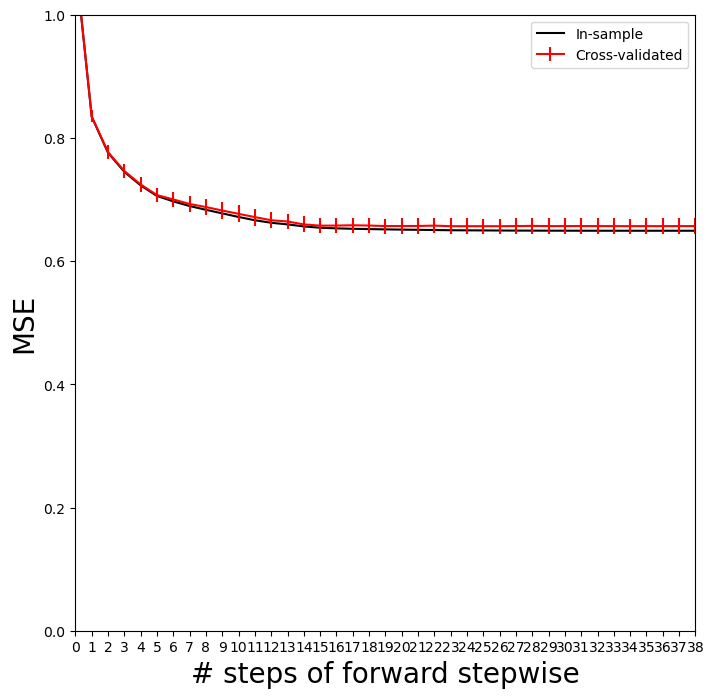

In [58]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.set_ylim([0,1])
ax.set_xlim([0, 14])
ax.set_xticks(np.arange(n_steps)[::])
ax.legend()
mse_fig

To repeat the above using the validation set approach, we simply change our
`cv` argument to a validation set: one random split of the data into a test and training. We choose a test size
of 20%, similar to the size of each test set in 5-fold cross-validation.`skm.ShuffleSplit()`

In [59]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(score_encoded.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(score_encoded.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)

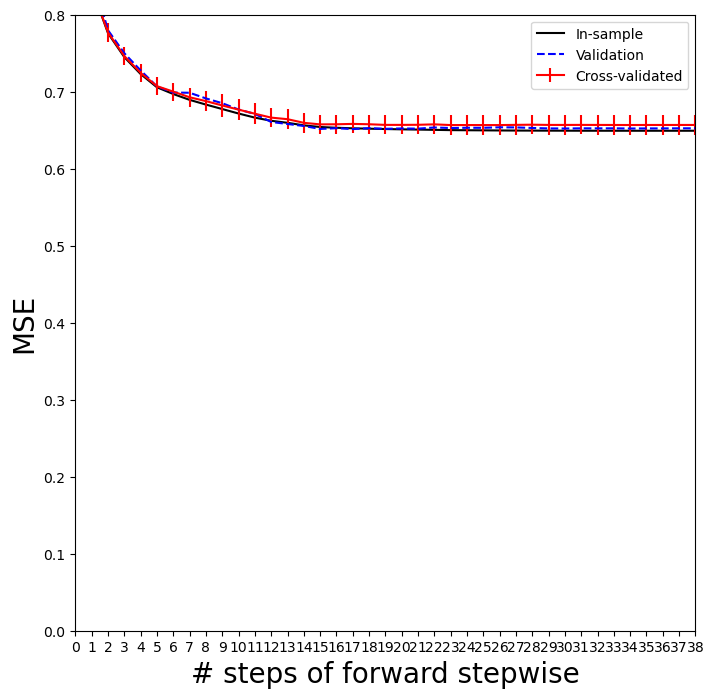

In [60]:
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([0,0.8])
ax.set_xlim([0, 14])
ax.set_xticks(np.arange(n_steps)[::])
ax.legend()
mse_fig

### Best Subset Selection
Forward stepwise is a *greedy* selection procedure; at each step it augments the current set by including one additional variable.  We now apply best subset selection  to the  `Hitters`
data, which for every subset size, searches for the best set of predictors.  

We will use a package called `l0bnb` to perform
best subset selection.
Instead of constraining the subset to be a given size,
this package produces a path of solutions using the subset size as a
penalty rather than a constraint. Although the distinction is subtle, the difference comes when we cross-validate.


In [61]:
D = design.fit_transform(score_encoded)
D = D.drop('intercept', axis=1)
X = np.asarray(D)


In [62]:
#convert to the same data type
X = X.astype(np.float64)  # or np.float32
Y = Y.astype(np.float64)  # or np.float32

In [63]:
#mutil-colinearity check 
print(np.linalg.matrix_rank(X), X.shape[1])


37 38


In [64]:
D.describe()

,class_size,dad_jhs_yn,female,mom_jhs_yn,ses,stuage,teacher_basepay,teacher_experience,zmathbase1,zmathbase2,...,countyid_109,countyid_110,countyid_111,countyid_201,countyid_202,countyid_203,countyid_204,countyid_205,countyid_206,countyid_207
count,7.373000e+03,7.373000e+03,7.373000e+03,7.373000e+03,7.373000e+03,7.373000e+03,7373.000000,7.373000e+03,7.373000e+03,7.373000e+03,...,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000,7373.000000
mean,-8.148851e-09,-3.645964e-09,-4.042089e-09,-2.215065e-09,3.252518e-18,3.013782e-08,0.000003,-3.233671e-09,2.457590e-09,-7.760811e-10,...,0.043808,0.029567,0.013427,0.099552,0.133731,0.059542,0.123695,0.051404,0.057778,0.059270
std,5.314953e+00,4.756159e-01,4.903067e-01,4.466593e-01,9.430391e-01,9.004887e-01,206.435226,1.957272e+00,8.852610e-01,8.928924e-01,...,0.204683,0.169402,0.115104,0.299423,0.340386,0.236652,0.329255,0.220835,0.233340,0.236146
min,-4.373333e+01,-9.024390e-01,-8.421053e-01,-8.139535e-01,-2.697501e+00,-3.296296e+00,-1393.548340,-1.243243e+01,-2.967198e+00,-2.932918e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,-4.666667e-01,-4.814815e-01,-3.478261e-01,-6.002458e-01,-6.615381e-01,0.000000,0.000000e+00,-6.044363e-01,-6.164764e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,1.904762e-01,-2.978723e-01,-1.714286e-01,-1.388402e-01,0.000000e+00,0.000000,0.000000e+00,3.636888e-02,5.553845e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000e+00,4.313725e-01,4.857143e-01,5.000000e-01,4.517266e-01,5.000000e-01,0.000000,0.000000e+00,6.373981e-01,6.511148e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.826667e+01,8.666667e-01,8.421053e-01,9.666666e-01,4.476572e+00,6.828571e+00,1322.000000,1.592982e+01,2.668667e+00,3.068696e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
D.columns

Index(['class_size', 'dad_jhs_yn', 'female', 'mom_jhs_yn', 'ses', 'stuage',
       'teacher_basepay', 'teacher_experience', 'zmathbase1', 'zmathbase2',
       'small', 'big', 'gains', 'p4p', 'levels', 'same_sex', 'f_same_sex',
       'same_sex_x_gains', 'same_sex_x_p4p', 'same_sex_x_levels',
       'f_same_sex_x_gains', 'f_same_sex_x_p4p', 'f_same_sex_x_levels',
       'countyid_104', 'countyid_105', 'countyid_106', 'countyid_107',
       'countyid_108', 'countyid_109', 'countyid_110', 'countyid_111',
       'countyid_201', 'countyid_202', 'countyid_203', 'countyid_204',
       'countyid_205', 'countyid_206', 'countyid_207'],
      dtype='object')

In [66]:
#path = fit_path(X,
                #Y,
                #max_nonzeros=X.shape[1])


## Ridge Regression and the Lasso
We will use the `sklearn.linear_model` package (for which
we use `skl` as shorthand below)
to fit ridge and  lasso regularized linear models on the `Hitters` data.
We start with the model matrix `X` (without an intercept) that we computed in the previous section on best subset regression.

### Ridge Regression
We will use the function `skl.ElasticNet()` to fit both  ridge and the lasso.
To fit a *path* of ridge regressions models, we use
`skl.ElasticNet.path()`, which can fit both ridge and lasso, as well as a hybrid mixture;  ridge regression
corresponds to `l1_ratio=0`.
It is good practice to standardize the columns of `X` in these applications, if the variables are measured in different units. Since `skl.ElasticNet()` does no normalization, we have to take care of that ourselves.
Since we
standardize first, in order to find coefficient
estimates on the original scale, we must *unstandardize*
the coefficient estimates. The parameter
$\lambda$ in (\ref{Ch6:ridge}) and (\ref{Ch6:LASSO}) is called `alphas` in `sklearn`. In order to
be consistent with the rest of this chapter, we use `lambdas`
rather than `alphas` in what follows.  {At the time of publication, ridge fits like the one in code chunk [22] issue unwarranted convergence warning messages; we expect these to disappear as this package matures.}

In [67]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4028.094865257724, tolerance: 0.8056189782463816
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did

(38, 100)

In [68]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,class_size,dad_jhs_yn,female,mom_jhs_yn,ses,stuage,teacher_basepay,teacher_experience,zmathbase1,zmathbase2,...,countyid_109,countyid_110,countyid_111,countyid_201,countyid_202,countyid_203,countyid_204,countyid_205,countyid_206,countyid_207
negative log(lambda),,,,,,,,,,,,,,,,,,,,,
-18.378537,1.640314e-10,1.037906e-09,-7.018905e-10,8.674967e-10,4.490296e-10,-2.494189e-09,-6.296595e-12,-6.690620e-11,5.024410e-09,5.252144e-09,...,3.360864e-10,6.035351e-10,1.568241e-10,1.991180e-10,-1.257311e-09,-4.282266e-10,-1.838216e-09,-2.923032e-10,-1.007882e-09,7.099736e-10
-18.145953,2.069841e-10,1.309689e-09,-8.856853e-10,1.094657e-09,5.666111e-10,-3.147309e-09,-7.945400e-12,-8.442605e-11,6.340087e-09,6.627454e-09,...,4.240930e-10,7.615749e-10,1.978896e-10,2.512584e-10,-1.586546e-09,-5.403607e-10,-2.319565e-09,-3.688448e-10,-1.271803e-09,8.958850e-10
-17.913368,2.611843e-10,1.652640e-09,-1.117608e-09,1.381300e-09,7.149822e-10,-3.971454e-09,-1.002596e-11,-1.065336e-10,8.000282e-09,8.362899e-09,...,5.351447e-10,9.609985e-10,2.497083e-10,3.170521e-10,-2.001995e-09,-6.818578e-10,-2.926959e-09,-4.654294e-10,-1.604833e-09,1.130479e-09
-17.680784,3.295772e-10,2.085395e-09,-1.410261e-09,1.743003e-09,9.022052e-10,-5.011407e-09,-1.265132e-11,-1.344301e-10,1.009521e-08,1.055278e-08,...,6.752760e-10,1.212643e-09,3.150962e-10,4.000744e-10,-2.526231e-09,-8.604070e-10,-3.693403e-09,-5.873052e-10,-2.025070e-09,1.426502e-09
-17.448200,4.158793e-10,2.631471e-09,-1.779548e-09,2.199420e-09,1.138454e-09,-6.323678e-09,-1.596415e-11,-1.696316e-10,1.273871e-08,1.331610e-08,...,8.521016e-10,1.530181e-09,3.976063e-10,5.048366e-10,-3.187741e-09,-1.085711e-09,-4.660547e-09,-7.410951e-10,-2.555348e-09,1.800042e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.716977,3.940724e-03,2.387462e-02,-1.609203e-01,1.180169e-02,7.032560e-03,-9.837258e-02,1.750809e-02,7.188654e-03,2.706157e-01,3.174268e-01,...,-1.733100e-02,1.163709e-02,-1.543930e-02,-6.293660e-02,-1.919332e-01,-9.294642e-02,-2.280193e-01,-7.434359e-02,-1.413815e-01,-9.929779e-03
3.949561,3.942921e-03,2.382854e-02,-1.632732e-01,1.171819e-02,7.023844e-03,-9.851166e-02,1.773287e-02,7.374735e-03,2.712763e-01,3.186289e-01,...,-1.966020e-02,9.793875e-03,-1.681173e-02,-6.668211e-02,-1.966559e-01,-9.605857e-02,-2.326529e-01,-7.700609e-02,-1.445913e-01,-1.276578e-02
4.182145,3.947164e-03,2.379212e-02,-1.651935e-01,1.165106e-02,7.018314e-03,-9.862138e-02,1.791218e-02,7.529302e-03,2.718005e-01,3.195904e-01,...,-2.168067e-02,8.188942e-03,-1.799925e-02,-6.991234e-02,-2.006945e-01,-9.873586e-02,-2.366141e-01,-7.929830e-02,-1.473371e-01,-1.521466e-02


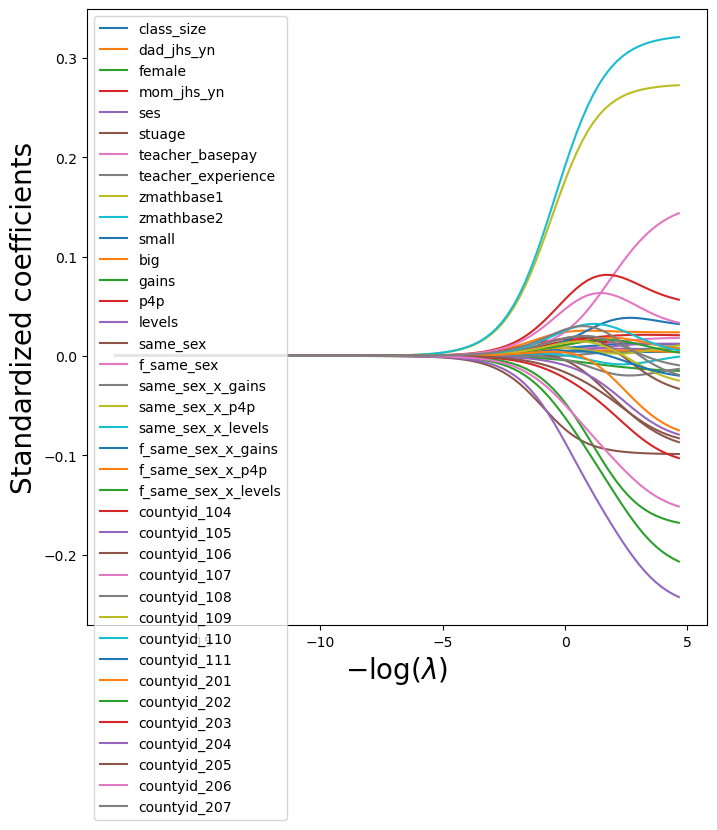

In [69]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [70]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(11023.087513634406,
 class_size             1.426341e-06
 dad_jhs_yn             9.025084e-06
 female                -6.104642e-06
 mom_jhs_yn             7.543112e-06
 ses                    3.904392e-06
 stuage                -2.168906e-05
 teacher_basepay       -5.456282e-08
 teacher_experience    -5.816666e-07
 zmathbase1             4.369286e-05
 zmathbase2             4.567347e-05
 small                  1.971404e-06
 big                    1.470327e-06
 gains                 -1.040292e-06
 p4p                    4.276822e-06
 levels                 7.029570e-07
 same_sex               2.313961e-06
 f_same_sex             4.525224e-06
 same_sex_x_gains       3.091575e-07
 same_sex_x_p4p         3.741609e-06
 same_sex_x_levels      1.582586e-06
 f_same_sex_x_gains     2.548797e-06
 f_same_sex_x_p4p       2.907571e-06
 f_same_sex_x_levels    3.238772e-06
 countyid_104           1.115431e-05
 countyid_105          -1.175921e-06
 countyid_106           4.274760e-06
 countyid_107    

In [71]:
np.linalg.norm(beta_hat)


7.454913308108708e-05

In [72]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)


(105.22071173788062, 0.007687724369451406)

In [73]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.987e+03, tolerance: 8.021e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=105.22071173788062, l1_ratio=0))])

In [74]:
np.linalg.norm(ridge.coef_)


0.007687724369451404

 Notice that the operation `pipe.fit(X, Y)` above has changed the `ridge` object, and in particular has added attributes such as `coef_` that were not there before.
### Estimating Test Error of Ridge Regression
Choosing an *a priori* value of $\lambda$ for ridge regression is
difficult if not impossible. We will want to use the validation method
or cross-validation to select the tuning parameter. The reader may not
be surprised that the  `Pipeline()` approach can be used in
`skm.cross_validate()` with either a validation method
(i.e. `validation`) or $k$-fold cross-validation.

We fix the random state of the splitter
so that the results obtained will be reproducible.

In [75]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+03, tolerance: 3.990e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([0.67833232])

In [76]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e+03, tolerance: 3.990e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([1.09352193])

In [77]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e+03, tolerance: 3.990e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e+03, tolerance: 3.990e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.009587319370752067, l1_ratio=0))])


Choosing $\lambda$ using cross-validati
.
.
.

In [78]:
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.202e+03, tolerance: 6.403e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.192e+03, tolerance: 6.384e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.009587319370752067, l1_ratio=0))])

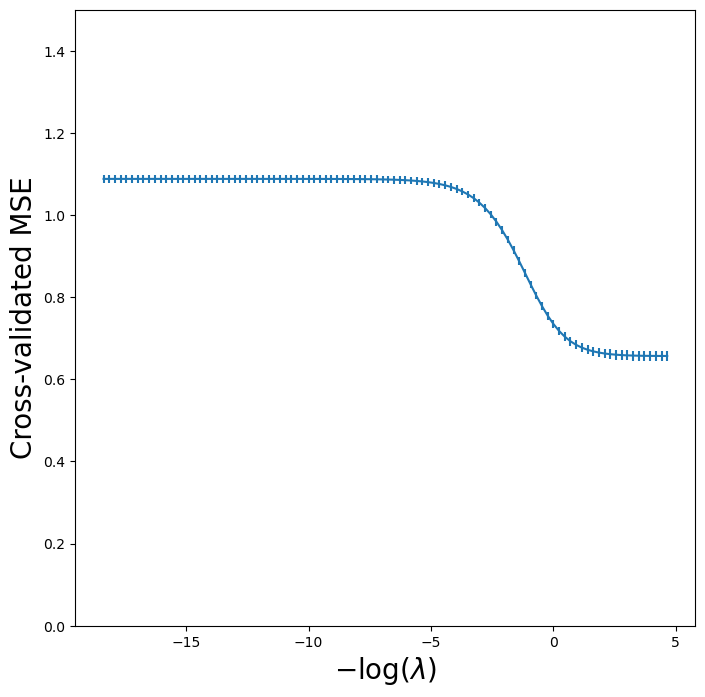

In [79]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([0,1.5])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


In [80]:
grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.202e+03, tolerance: 6.403e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.192e+03, tolerance: 6.384e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([9.58731937e+07, 7.59778664e+07, 6.02111598e+07, 4.77163144e+07,
       3.78143632e+07, 2.99672361e+07, 2.37485221e+07, 1.88202976e+07,
       1.49147640e+07, 1.18196954...
       2.01803883e+00, 1.59926126e+00, 1.26738720e+00, 1.00438268e+00,
       7.95956097e-01, 6.30781595e-01, 4.99883627e-01, 3.96149225e-01,
       3.13941486e-01, 2.48793259e-01, 1.97164403e-01, 1.56249417e-01,
       1.23824991e-01, 9.81291879e-02, 7.77657033e-02, 6.16279899e-02,
       4.88391281e-02, 3.87041738e-02, 3.06723958e-02, 2.43073491e-02,
       1.92631585e-02, 1.52657237e-02, 1.20978249e-02, 9.58731937e-03])})

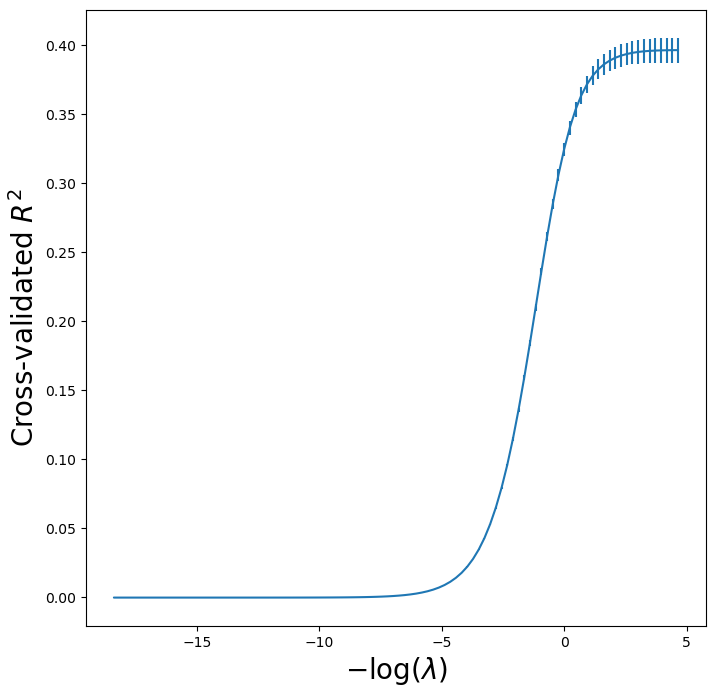

In [81]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);


In [82]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3201.653489017013, tolerance: 0.64033070201055
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did n

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([9.58731937e+07, 7.59778664e+07, 6.02111598e+07, 4.77163144e+07,
       3.78143632e+07, 2.99672361e+07, 2.37485221e+07, 1.88202976e+07,
       1.49147640e+07, 1.18196954e+07, 9.36690649e+06, 7.42311320e+06,
       5.88269027e+06, 4.66193143e+06, 3.69450093e+06, 2.92782881e+06,
       2.32025426e+06, 1.83876182e+06,...
       7.95956097e-01, 6.30781595e-01, 4.99883627e-01, 3.96149225e-01,
       3.13941486e-01, 2.48793259e-01, 1.97164403e-01, 1.56249417e-01,
       1.23824991e-01, 9.81291879e-02, 7.77657033e-02, 6.16279899e-02,
       4.88391281e-02, 3.87041738e-02, 3.06723958e-02, 2.43073491e-02,
       1.92631585e-02, 1.52657237e-02, 1.20978249e-02, 9.58731937e-03]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

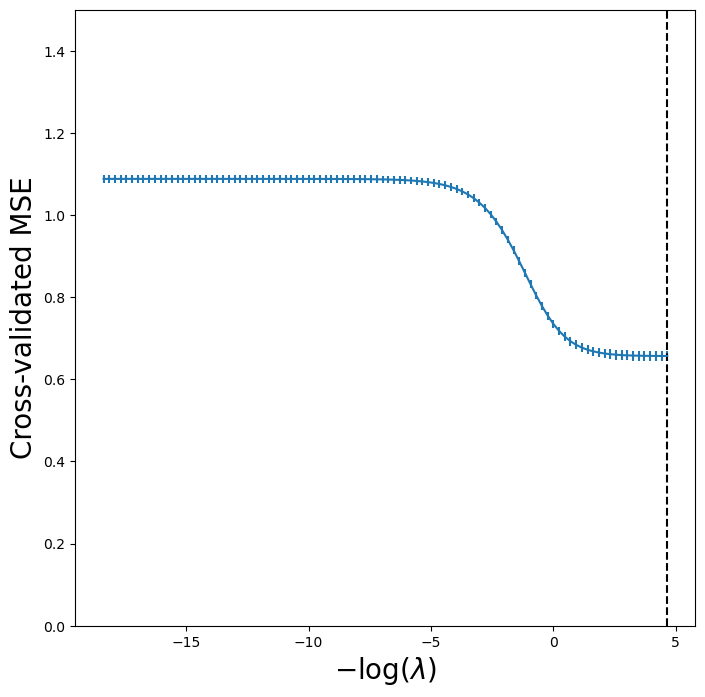

In [97]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([0,1.5])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


In [93]:
soln_path.columns


Index(['class_size', 'dad_jhs_yn', 'female', 'mom_jhs_yn', 'ses', 'stuage',
       'teacher_basepay', 'teacher_experience', 'zmathbase1', 'zmathbase2',
       'small', 'big', 'gains', 'p4p', 'levels', 'same_sex', 'f_same_sex',
       'same_sex_x_gains', 'same_sex_x_p4p', 'same_sex_x_levels',
       'f_same_sex_x_gains', 'f_same_sex_x_p4p', 'f_same_sex_x_levels',
       'countyid_104', 'countyid_105', 'countyid_106', 'countyid_107',
       'countyid_108', 'countyid_109', 'countyid_110', 'countyid_111',
       'countyid_201', 'countyid_202', 'countyid_203', 'countyid_204',
       'countyid_205', 'countyid_206', 'countyid_207'],
      dtype='object')

In [ ]:
v = ['class_size', 'dad_jhs_yn', 'female', 'mom_jhs_yn', 'ses', 'stuage',
       'teacher_basepay', 'teacher_experience', 'zmathbase1', 'zmathbase2',
       'gains', 'p4p', 'levels', 'same_sex', 'f_same_sex']

In [ ]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

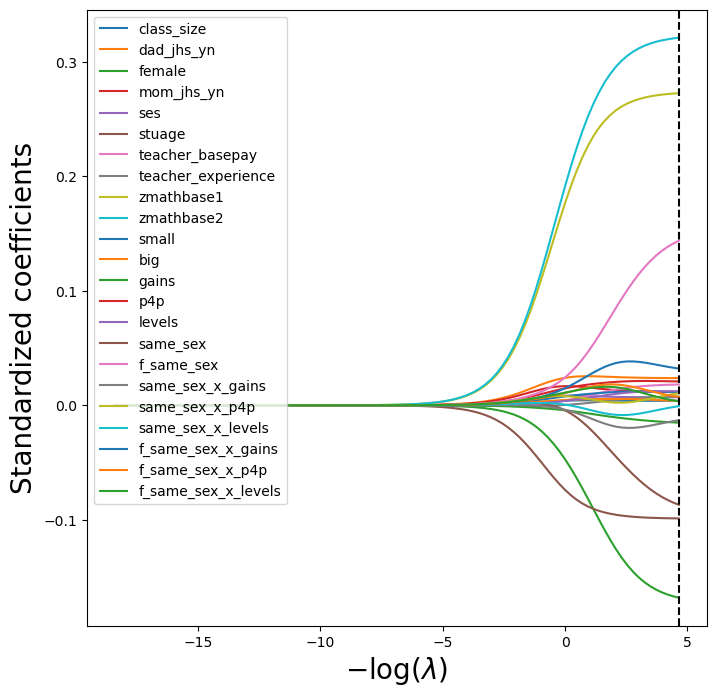

In [95]:
path_fig, ax = subplots(figsize=(8,8))

soln_path[v].plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')


### Evaluating Test Error of Cross-Validated Ridge


In [239]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);


In [240]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2419.7205070029054, tolerance: 0.48394410446627467
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective d

array([0.64576978])

### The Lasso
We saw that ridge regression with a wise choice of $\lambda$ can
outperform least squares as well as the null model on the
 `Hitters`  data set. We now ask whether the lasso can yield
either a more accurate or a more interpretable model than ridge
regression. In order to fit a lasso model, we once again use the
`ElasticNetCV()`  function; however, this time we use the argument
`l1_ratio=1`. Other than that change, we proceed just as we did in
fitting a ridge model.

In [98]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


0.000943541734376006

In [99]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))


We can see from the coefficient plot of the standardized coefficients that depending on the choice of
tuning parameter, some of the coefficients will be exactly equal to
zero.

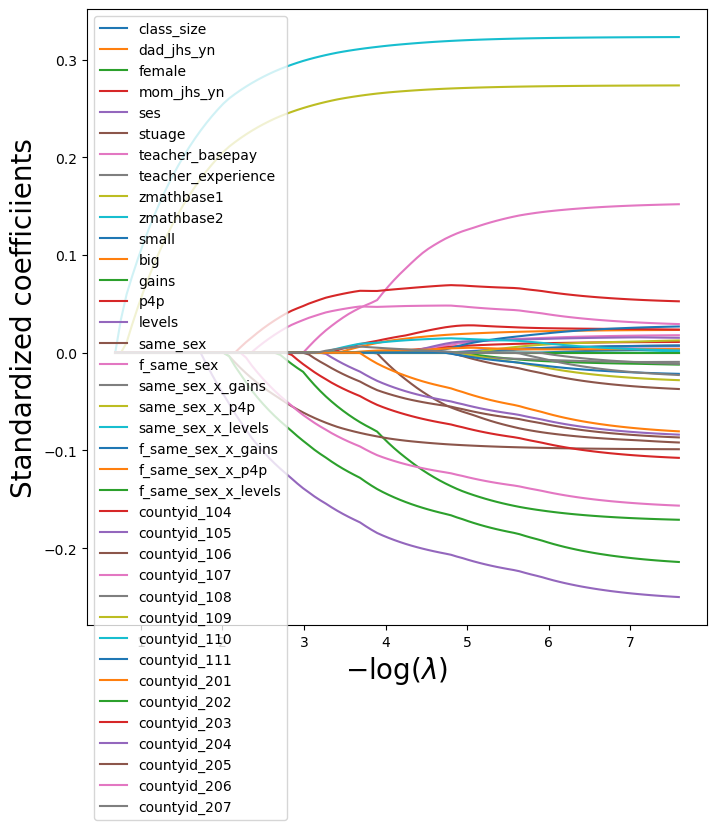

In [100]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);


The smallest cross-validated error is lower than the test set MSE of the null model
and of least squares, and very similar to the test MSE of 115526.71 of ridge
regression (page~\pageref{page:MSECVRidge}) with $\lambda$ chosen by cross-validation.

In [101]:
np.min(tuned_lasso.mse_path_.mean(1))


0.656726857902421

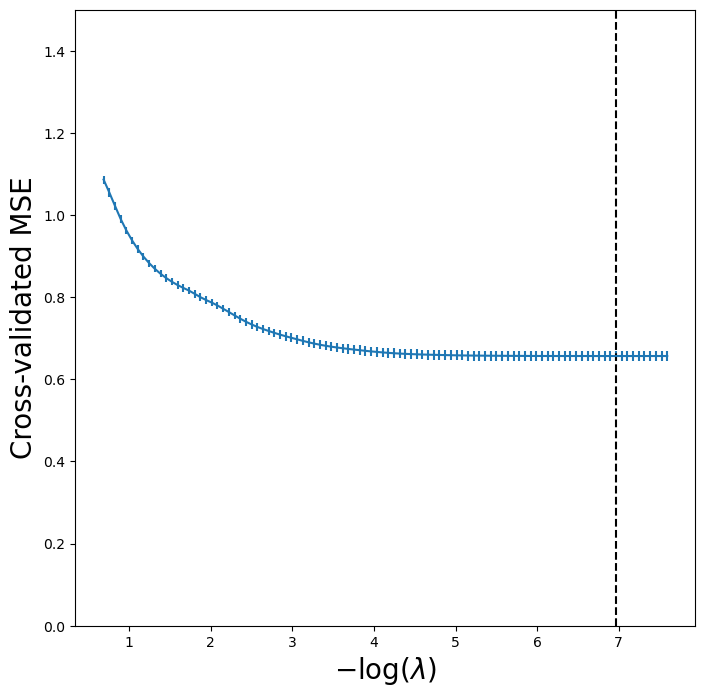

In [102]:
#cross-validation error plot
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0,1.5])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

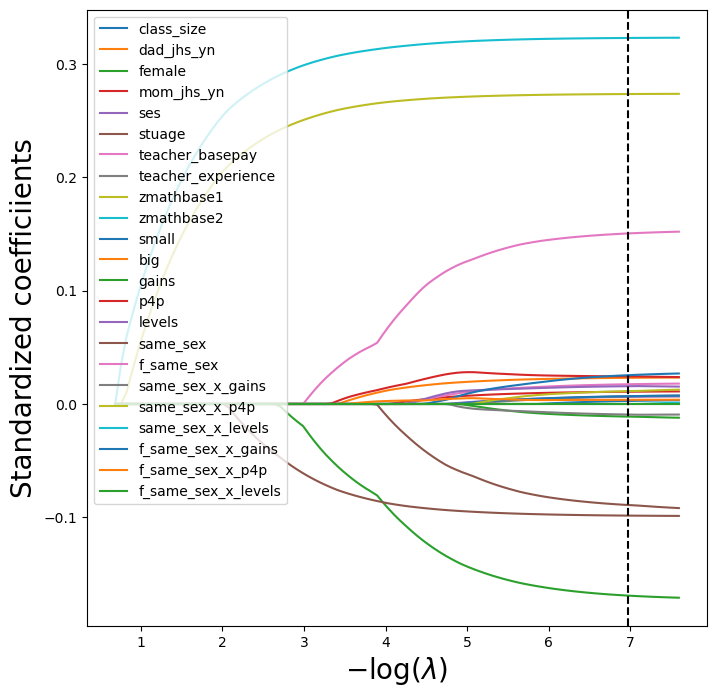

In [104]:
path_fig, ax = subplots(figsize=(8,8))
soln_path[v].plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')


However, the lasso has a substantial advantage over ridge regression
in that the resulting coefficient estimates are sparse. Here we see
that 6 of the 19 coefficient estimates are exactly zero. So the lasso
model with $\lambda$ chosen by cross-validation contains only 13
variables.

In [246]:
tuned_lasso.coef_


array([ 0.00266309,  0.02307859, -0.16904703,  0.01081117,  0.00626882,
       -0.09845903,  0.01741091,  0.00678614,  0.27341078,  0.32287472,
        0.00689366, -0.        , -0.01116078,  0.02426992,  0.01568123,
       -0.08915606,  0.15046369, -0.00925536,  0.01135511,  0.        ,
        0.02536319,  0.00367403,  0.        ,  0.05479543, -0.08066845,
       -0.03381162,  0.03159474, -0.00915323, -0.02528102,  0.00396547,
       -0.01981187, -0.07640743, -0.20968184, -0.10441432, -0.24586967,
       -0.08371556, -0.15337818, -0.01932605])

# Regression Tree

In [247]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)


In [248]:
model = MS(score_encoded.columns.drop('z_final_score'), intercept=False)
D = model.fit_transform(score_encoded)
feature_names = list(D.columns)
X = np.asarray(D)

In [249]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                score_encoded['z_final_score'],
                                test_size=0.3,
                                random_state=0)

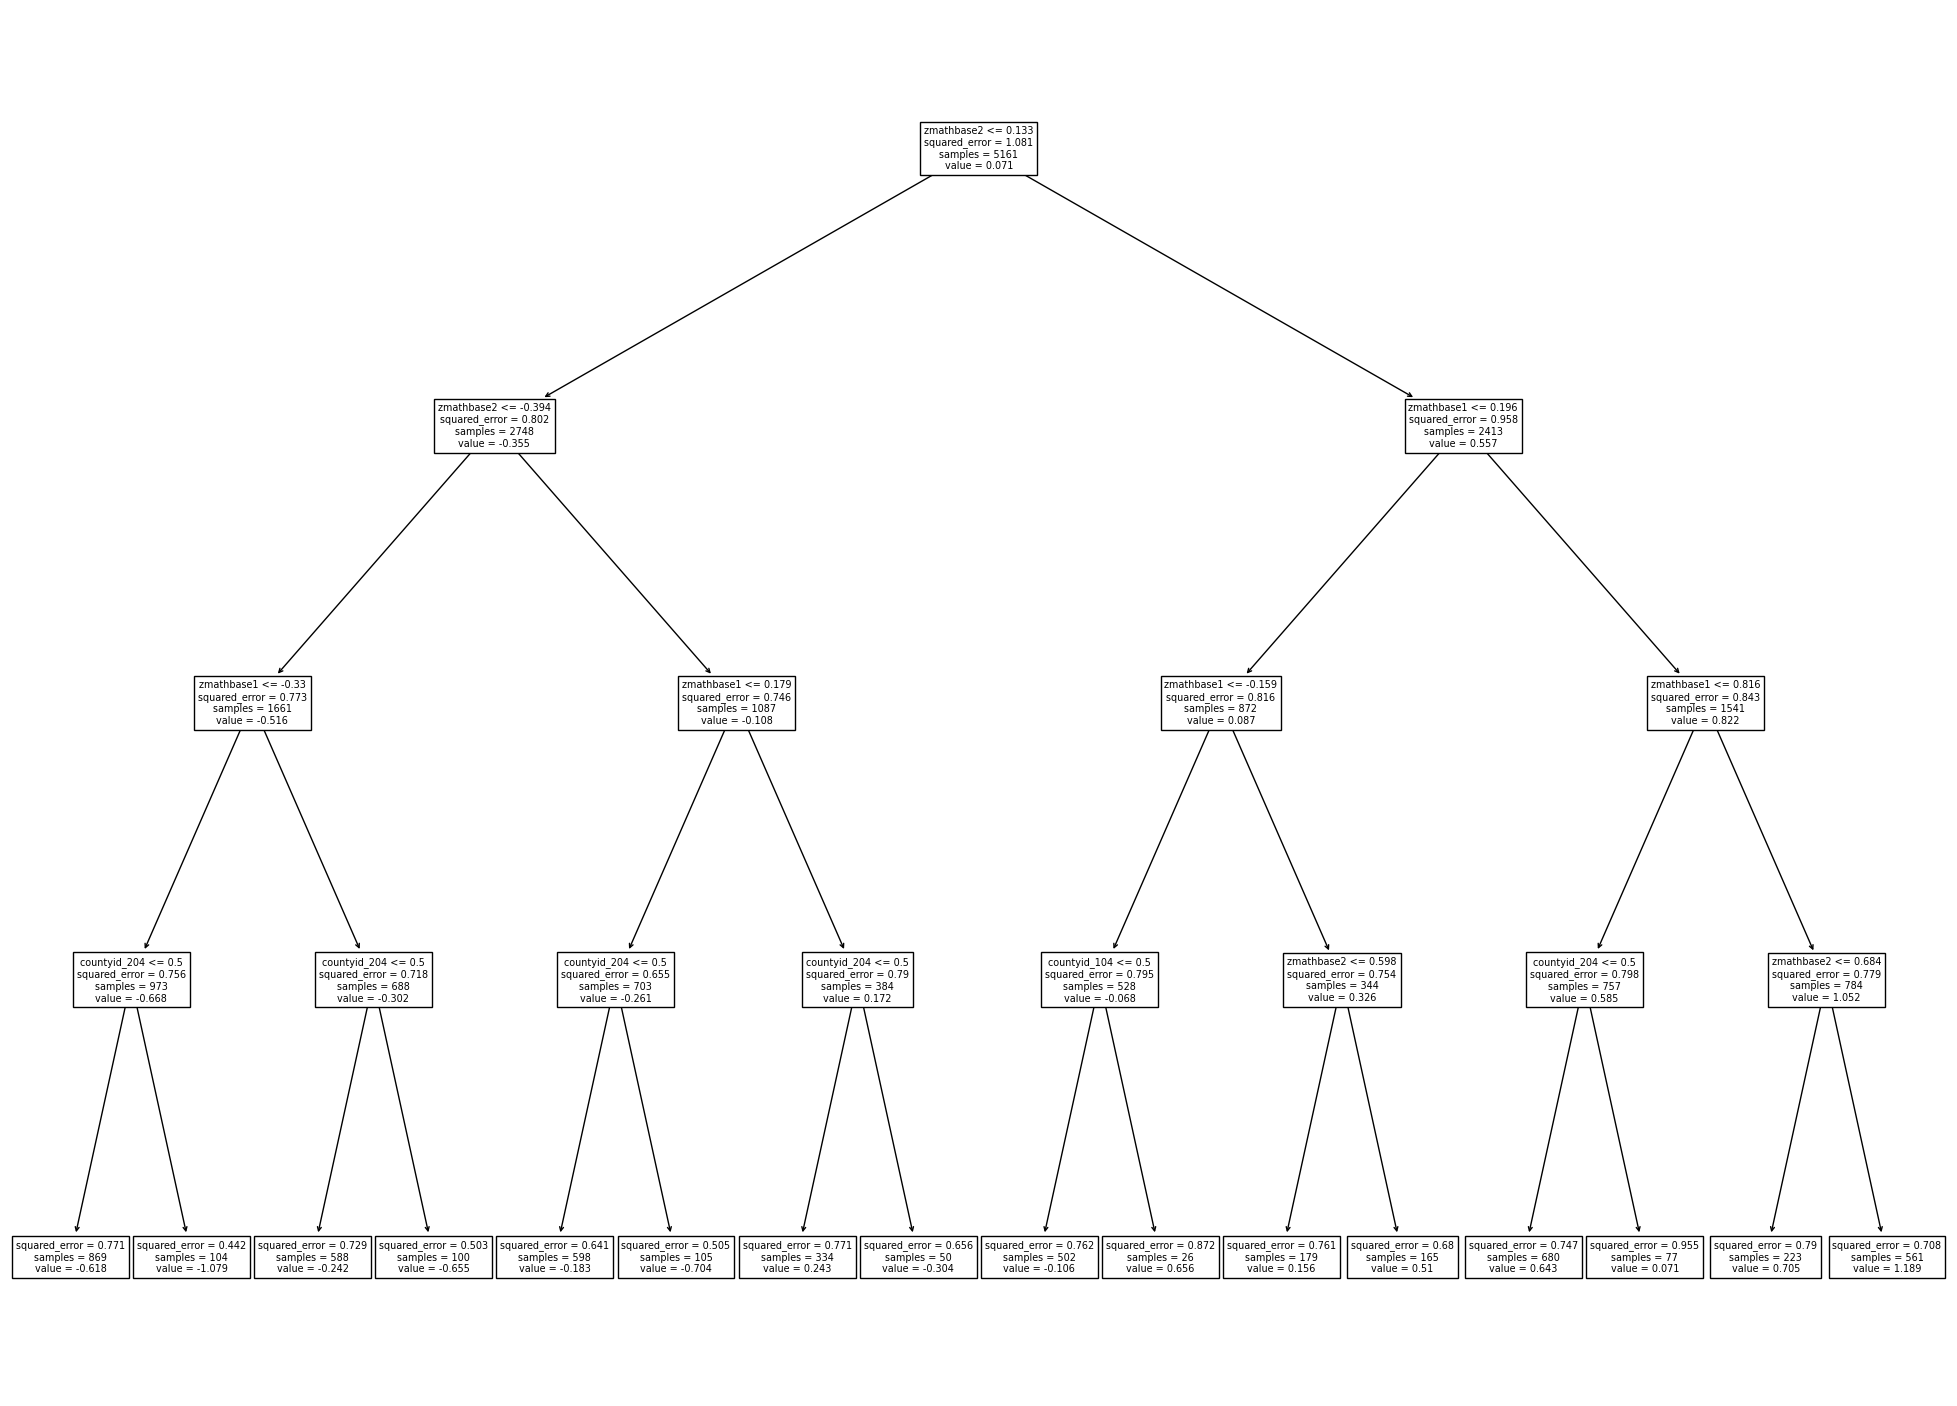

In [250]:
reg = DTR(max_depth=4)
reg.fit(X_train, y_train)
ax = subplots(figsize=(25,18))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);




In [251]:


# Calculate MSE
np.mean((y_test - reg.predict(X_test))**2)



0.7668020721312411

In [252]:
#cross-validation tree pruning.
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)


In [253]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)
#cross validation MSE


0.7668020721312411

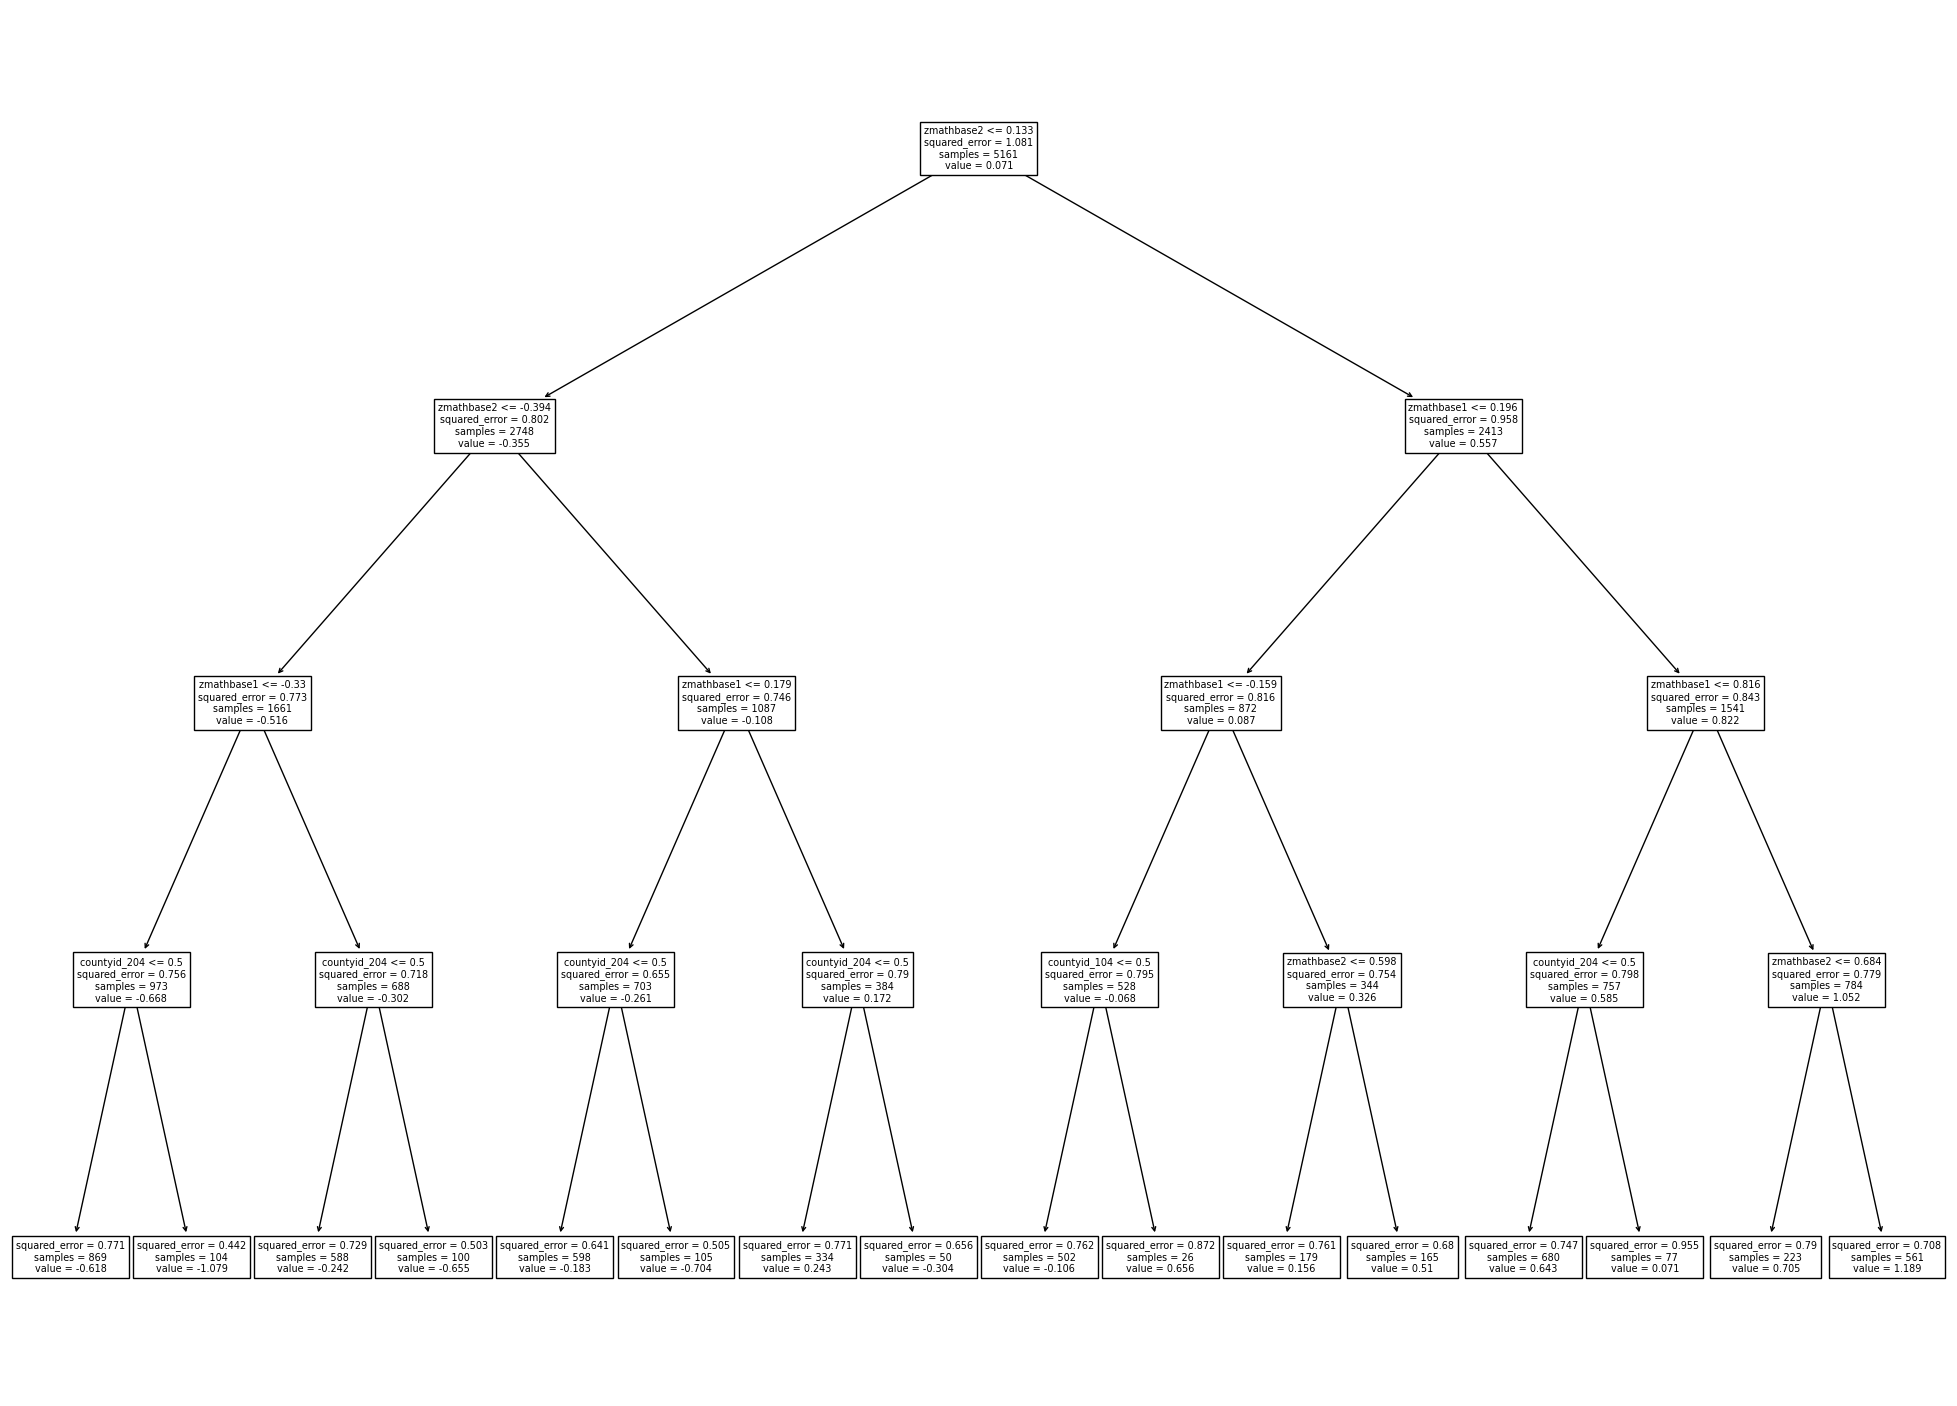

In [254]:
ax = subplots(figsize=(25,18))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

## Bagging and Random Forests

In [255]:
bag_score = RF(max_features=X_train.shape[1], random_state=0)
bag_score.fit(X_train, y_train)


RandomForestRegressor(max_features=38, random_state=0)

0.6605953165830608

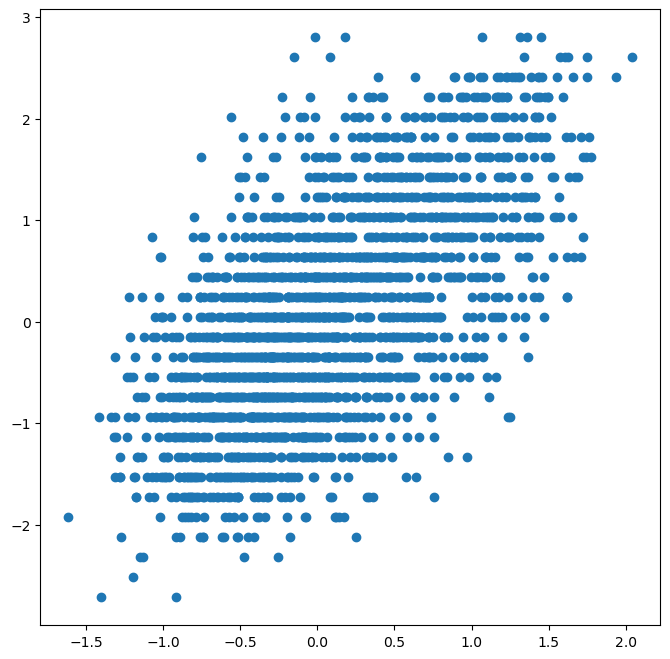

In [256]:
#normal bagging MSE
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_score.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [257]:
#using all predcitors but with more trees
#checking change in MSE
bag_score = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_score.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

0.6516524658905142

In [258]:
#caping the number of predictors = RF
#checking MSE
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)
#higher values meansing RF is worse than bagging

0.6105708033551075

In [259]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
zmathbase2,0.213145
zmathbase1,0.195576
stuage,0.088527
ses,0.075887
mom_jhs_yn,0.068642
dad_jhs_yn,0.063649
female,0.061904
countyid_204,0.021000
countyid_202,0.014925
countyid_104,0.012433


In [260]:
latex = feature_imp.sort_values(by='importance', ascending=False).style.to_latex()
print(latex)

\begin{tabular}{lr}
 & importance \\
zmathbase2 & 0.213145 \\
zmathbase1 & 0.195576 \\
stuage & 0.088527 \\
ses & 0.075887 \\
mom_jhs_yn & 0.068642 \\
dad_jhs_yn & 0.063649 \\
female & 0.061904 \\
countyid_204 & 0.021000 \\
countyid_202 & 0.014925 \\
countyid_104 & 0.012433 \\
class_size & 0.010895 \\
big & 0.010877 \\
same_sex & 0.010792 \\
teacher_basepay & 0.010633 \\
small & 0.010116 \\
teacher_experience & 0.010111 \\
p4p & 0.009040 \\
gains & 0.008076 \\
countyid_206 & 0.008011 \\
levels & 0.007648 \\
countyid_107 & 0.007265 \\
f_same_sex & 0.007132 \\
same_sex_x_p4p & 0.006580 \\
countyid_207 & 0.006207 \\
countyid_205 & 0.005985 \\
countyid_201 & 0.005574 \\
countyid_105 & 0.005485 \\
same_sex_x_gains & 0.005387 \\
same_sex_x_levels & 0.005067 \\
countyid_110 & 0.004920 \\
countyid_106 & 0.004354 \\
countyid_203 & 0.003875 \\
countyid_109 & 0.003854 \\
f_same_sex_x_gains & 0.003803 \\
countyid_111 & 0.003746 \\
f_same_sex_x_p4p & 0.003078 \\
f_same_sex_x_levels & 0.003023 \\
co

## Boosting


In [261]:
boost_score = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_score.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

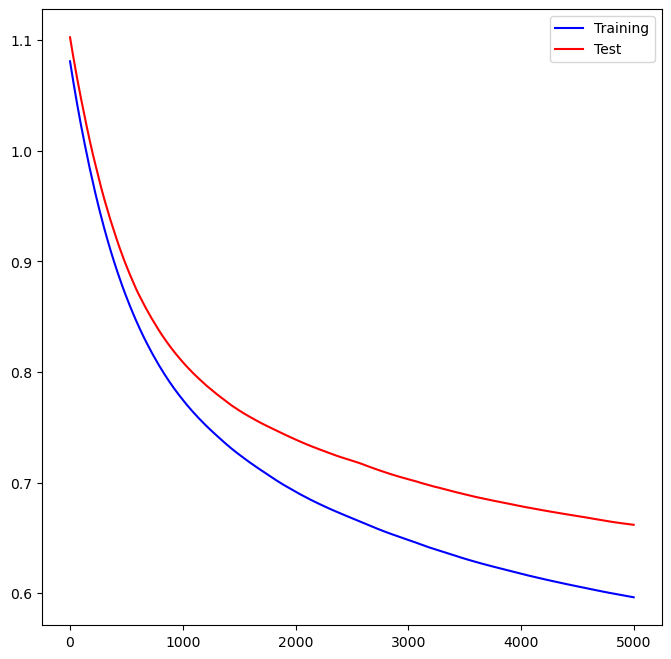

In [262]:
#
test_error = np.zeros_like(boost_score.train_score_)
for idx, y_ in enumerate(boost_score.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_score.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_score.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

#MSE error y-axis

In [263]:
#predicting y hat
y_hat_boost = boost_score.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


0.6617858382950254

In [264]:
#fine tunning the number of trees =1000
boost_score = GBR(n_estimators=500,
                   learning_rate=0.02,
                   max_depth=3,
                   random_state=0)
boost_score.fit(X_train,
                 y_train)
y_hat_boost = boost_score.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


0.6224659711999332

In [265]:
#fine tunning the learning rate  = 0.2
boost_score = GBR(n_estimators=500,
                   learning_rate=0.02,
                   max_depth=3,
                   random_state=0)
boost_score.fit(X_train,
                 y_train)
y_hat_boost = boost_score.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

0.6224659711999332

# DAG Model


In [1]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [2]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [3]:
import networkx as nx

In [269]:
# Define the graph
gml_graph = """graph [
directed 1

node [
    id age
    label "age"
    ]

node [
    id ability
    label "ability"
    unobserved 1
    ]
    
node [
    id zmathbase1
    label "test1"
    ]
        
node [
    id zmathbase2
    label "test2"
    ]
    
node [
    id z_final_score
    label "z_final_score"
    ]


edge [
    source age
    target ability
    ]
    
edge [
    source ability
    target zmathbase1
    ]
        
edge [
    source ability
    target zmathbase2
    ]
edge [
    source zmathbase1
    target z_final_score
    ]
edge [
    source zmathbase1
    target zmathbase2
    ]
edge [
    source zmathbase2
    target z_final_score
    ]
    
    
node [
    id class_size
    label "c_size"
    ]
node [
    id teacher_experience 
    label "t_exp"
    ]
node [
    id teacher_basepay
    label "t_pay"
    ]
node [
    id class_quality
    label "c_quality"
    unobserved 1
    ]


edge [
    source class_size
    target class_quality
    ]
edge [
    source teacher_basepay
    target class_quality
    ]
edge [
    source teacher_experience
    target class_quality
    ]
edge [
    source teacher_experience
    target teacher_basepay
    ]

edge [
    source class_quality
    target zmathbase1
    ]

edge [
    source class_quality
    target zmathbase2
    ]
    
    
    
node [
    id females
    label "females"
    
    ]
node [
    id t_female
    label "t_female"
    ]
node [
    id female
    label "female"
    ]  

edge [
    source t_female
    target females
    ]
    
edge [
    source female
    target females
    ]
    
edge [
    source females
    target zmathbase2
    ]
    
edge [
    source females
    target zmathbase1
    ]
    
edge [
    source females
    target z_final_score
    ]

  
node [
    id dad_jhs_yn
    label "dad_edu"
    ]
node [
    id mom_jhs_yn 
    label "mom_edu"
    ]
node [
    id ses
    label "ses"
    ]
node [
    id family_investment
    label "invest"
    unobserved 1
    ]
    
edge [
    source dad_jhs_yn
    target family_investment
    ]
edge [
    source mom_jhs_yn
    target family_investment
    ]
edge [
    source ses
    target family_investment
    ]
edge [
    source family_investment
    target z_final_score
    ]
    
    
node [
    id interaction_term
    label "interaction_term"
    ]
edge [
    source class_size
    target interaction_term
    ]
    
edge [
    source teacher_experience
    target interaction_term
    ]
    
edge [
    source interaction_term
    target z_final_score
    ]
    
edge [
    source t_female
    target interaction_term
    ]
    
]
    """

In [270]:
# Define manual positions for specific clusters
pos = {
    # Family characteristics grouped in the same corner
    'dad_jhs_yn': [-1, 1],
    'mom_jhs_yn': [-1, 0.5],
    'ses': [-1, 0],
    
    # The "investment" related node near family characteristics
    'family_investment': [-0.5, 0.75],
    
    # Test scores and final score
    'zmathbase1': [0.5, 1],
    'zmathbase2': [0.5, 0.5],
    'z_final_score': [1, 0.75],
    
    # Class characteristics
    'class_size': [0.5, -0.5],
    'teacher_experience': [1, -0.5],
    'teacher_basepay': [1.5, -0.5],
    'class_quality': [1, -1],
    
    # Gender-related variables
    'female': [-0.5, -0.5],
    't_female': [-1, -0.75],
    'females': [-0.75, -0.5],
    
    # Other variables
    'interaction_term': [1.5, 0.5],
    'age': [0, -1],
    'ability': [0.5, 0]
}

# Apply a spring layout for the remaining nodes, without overwriting manual positions
remaining_pos = nx.spring_layout(graph, k=0.7, pos=pos, fixed=pos.keys(), iterations=100)

# Combine the manual and automatic positions
pos.update(remaining_pos)

# Plot the graph with fixed layout for clusters and spring layout for the rest
plt.figure(figsize=(15, 10))
nx.draw(
    G=graph, 
    pos=pos,
    with_labels=True,
    node_size=3000,
    node_color='skyblue',
    font_color='black',
    font_size=10,
    edge_color='gray',
    arrows=True,
    arrowstyle='->',
    arrowsize=10
)

plt.title("Structural Causal Model (SCM)")
plt.show()

NameError: name 'graph' is not defined

In [ ]:
!pip install dowhy -q
import dowhy
from dowhy import CausalModel

In [ ]:
# With graph
covariates = base_covs + other_covs

model = CausalModel(
    data=control_encoded,
    treatment=['t_female'],
    outcome='z_final_score',
    common_causes=covariates,
    graph=gml_graph
)



In [ ]:
model.view_model()

In [ ]:
estimand = model.identify_effect()
print(estimand)

In [ ]:
import dowhy.datasets, dowhy.plotter

estimate = model.estimate_effect(estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))


In [ ]:
refute_subset = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.4)

In [ ]:
print(refute_subset)

In [ ]:
refute_random=model.refute_estimate(estimand,
                                    estimate, 
                                    method_name="random_common_cause", 
                                    show_progress_bar=True)


In [ ]:
print(refute_random)

# Linear Regression

In [271]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf


In [272]:
Y = score_transformed['z_final_score']
Z = score_transformed.drop(['z_final_score'], axis=1)


In [273]:
#data split
train, test = train_test_split(score_transformed, test_size=0.20, random_state=123)

In [274]:

# 1. Base Model

model_base ='z_final_score ~ zmathbase1 + zmathbase2 +\
C(countyid) + stuage +  dad_jhs_yn + mom_jhs_yn +\
ses + class_size + teacher_experience + teacher_basepay + \
same_sex + female +f_same_sex + small + big + gains + p4p + levels '


base = smf.ols(model_base, data=train)
results_base = base.fit()

results_base.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          z_final_score   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     126.3
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        01:51:19   Log-Likelihood:                -7102.0
No. Observations:                5898   AIC:                         1.427e+04
Df Residuals:                    5866   BIC:                         1.448e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3555      0.044      8.120      0.000       0.270       0.441
C(countyid)[T.104]     0.2261      0.059      3.825      0.000       0.110       0.342
C(countyid)[T.105]    -0.3423      0.058     -5.898      0.000      -0.456      -0.229
C(countyid)[T.106]    -0.1829      0.058     -3.146      0.002      -0.297      -0.069
C(countyid)[T.107]     0.1103      0.060      1.833      0.067      -0.008       0.228
C(countyid)[T.108]    -0.1028      0.085     -1.209      0.227      -0.270       0.064
C(countyid)[T.109]    -0.1442      0.065     -2.234      0.026      -0.271      -0.018
C(countyid)[T.110]    -0.0216      0.073     -0.294      0.768      -0.165       0.122
C(countyid)[T.111]    -0.2530      0.102     -2.490      0.013      -0.452      -0.054
C(countyid)[T.201]    -0.2646      0.051     -5.188      0.000      -0.365      -0.165
C(countyid)[T.202]    -0.6379      0.048    -13.292      0.000      -0.732      -0.544
C(countyid)[T.203]    -0.4516      0.059     -7.671      0.000      -0.567      -0.336
C(countyid)[T.204]    -0.7628      0.049    -15.430      0.000      -0.860      -0.666
C(countyid)[T.205]    -0.3664      0.062     -5.939      0.000      -0.487      -0.245
C(countyid)[T.206]    -0.7038      0.059    -11.893      0.000      -0.820      -0.588
C(countyid)[T.207]    -0.1045      0.058     -1.815      0.070      -0.217       0.008
zmathbase1             0.3075      0.015     21.194      0.000       0.279       0.336
zmathbase2             0.3535      0.014     24.441      0.000       0.325       0.382
stuage                -0.1053      0.012     -8.450      0.000      -0.130      -0.081
dad_jhs_yn             0.0430      0.023      1.868      0.062      -0.002       0.088
mom_jhs_yn             0.0393      0.025      1.603      0.109      -0.009       0.087
ses                    0.0019      0.011      0.171      0.864      -0.020       0.024
class_size             0.0024      0.002      1.141      0.254      -0.002       0.006
teacher_experience     0.0084      0.006      1.453      0.146      -0.003       0.020
teacher_basepay        0.0001    5.4e-05      1.867      0.062   -5.07e-06       0.000
same_sex              -0.1892      0.031     -6.180      0.000      -0.249      -0.129
female                -0.3615      0.031    -11.563      0.000      -0.423      -0.300
f_same_sex             0.4162      0.045      9.189      0.000       0.327       0.505
small                  0.0505      0.019      2.621      0.009       0.013       0.088
big                    0.0215      0.019      1.112      0.266      -0.016       0.059
gains                 -0.0274      0.020     -1.394      0.164      -0.066       0.011
p4p                    0.0620      0.020      3.063      0.002       0.022       0.102
levels                 0.0374      0.0

In [ ]:
# 1. Interaction Model

model_interaction ='z_final_score ~ zmathbase1 + zmathbase2 +\
C(countyid) + stuage +  dad_jhs_yn + mom_jhs_yn +\
ses + class_size + teacher_experience + teacher_basepay + \
same_sex + female +f_same_sex + small + big + gains + p4p + levels +\
same_sex_x_gains + same_sex_x_p4p + same_sex_x_levels + f_same_sex_x_gains+\
f_same_sex_x_p4p + f_same_sex_x_levels'




    , 

base1 = smf.ols(model_interaction, data=train)
results_base1 = base.fit()

results_base1.summary()

In [ ]:
latex_output = results_base.summary().as_latex ()
print(latex_output )


In [ ]:
#testing determinant characteristics to students outcome
rsquared_base = results_base.rsquared
rsquared_adj_base = results_base.rsquared_adj
mse_base = np.mean(results_base.resid**2)
mse_adj_base = results_base.mse_resid
print(f'Rsquared={rsquared_base:.4f}')
print(f'Rsquared_adjusted={rsquared_adj_base:.4f}')
print(f'MSE={mse_base:.4f}')
print(f'MSE_adjusted={mse_adj_base:.4f}')